In [1]:
%matplotlib inline

import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import median, mean
from pprint import pprint
import sys
from glob import glob

from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from IPython.display import display

CALLERS = ['strelka2', 'vardict', 'mutect2']

CALLER = 'strelka2'
venn_field = 'caller'
#venn_left = 'strelka2'
#venn_right = 'ensemble'
venn_left = 'vardict'
venn_right = 'strelka2'
vl = venn_left
vr = venn_right
l = vl[0]
r = vr[0]

benchmark_d = {
    'mb_100v100': {
        'src_vcf': 'batch1-{c}-annotated.vcf.gz',
        'bench': 'mb',
    },
    'mb_300v50': {
        'src_vcf': 'MB_300vs50-{c}-annotated.vcf.gz',
        'bench': 'mb',
    },
    'colo_40pc_ds': {
        'src_vcf': 'COLO829_40pc_ds-{c}.vcf.gz',
        'bench': 'colo',
    },
    'colo_40pc_full': {
        'src_vcf': 'COLO829_40pc-{c}.vcf.gz',
        'bench': 'colo',
    },
    'colo_tgen': {
        'src_vcf': 'COLO_TGEN_bwa-{c}.vcf.gz',
        'bench': 'colo',
    },
    'colo_hoffman': {
        'src_vcf': 'COLO829_40pc-{c}.vcf.gz',
        'bench': 'colo',
    },
}
for n, d in benchmark_d.items():
    d['name'] = n
    d['df'] = None
    d['eval_dir'] = f'{n}/evalled'
    d['vcf_glob'] = f'{d["eval_dir"]}/anno_gnomad/*{{c}}*/*{{c}}*.vcf.gz'
    d['truth_vcf'] = f'{d["eval_dir"]}/anno_gnomad/truth_variants.vcf.gz'
MinEVS = 6

In [14]:
from ngs_utils.file_utils import add_suffix, file_exists, splitext_plus, intermediate_fname
from os.path import basename, splitext, dirname, join

def _load(n):
    d = benchmark_d[n]
#    print(f'Benchmarking VCFs for {n}')
    vcfs = []
    eval_dir = f'{n}/evalled'
    vcfprep_dir = f'{n}/vcfprep'
    !mkdir -p {vcfprep_dir}
    for c in CALLERS:
        vcf = join(n, d['src_vcf'].format(c=c))
        if file_exists(vcf):
#             vcf_pass = intermediate_fname(vcfprep_dir, vcf, 'pass')
#             if not file_exists(vcf_pass):
#                 cmd = f'bcftools view -f.,PASS {vcf} -Oz -o {vcf_pass} && tabix -p vcf {vcf_pass}'
#                 print(cmd)
#                 !{cmd}
#             vcf_prep = intermediate_fname(vcfprep_dir, vcf, 'prep')
#             if not file_exists(vcf_prep):
#                 cmd = f'pcgr_prep {vcf_pass} | bcftools view -f.,PASS -Oz -o {vcf_prep} && tabix -p vcf {vcf_prep}'
#                 print(cmd)
#                 !{cmd}
#             vcf_pon = intermediate_fname(vcfprep_dir, vcf, 'pon')
#             if not file_exists(vcf_pon):
#                 cmd = f'pon_anno {vcf_prep} -o {vcf_pon} && tabix -p vcf {vcf_pon}'
#                 print(cmd)
#                 !{cmd}
            vcfs.append(vcf)
#             vcf_basename = splitext_plus(basename(vcf_pon))[0]
#             d['isec_dir'] = f'{eval_dir}/eval/{vcf_basename}_bcftools_isec'.replace(c, '{c}')

    if vcfs:
        cmd = f"eval_vcf {d['bench']} {' '.join(vcfs)} -o {eval_dir} --anno-tricky --anno-dp-af --anno-pon --anno-gnomad"
        print(cmd)
        # !{cmd}

    for c in CALLERS:
        vcf_glob = glob(d['vcf_glob'].format(c=c))
        if vcf_glob:
            vcf = vcf_glob[0]
            sname = basename(splitext_plus(vcf)[0])            
            pcgr_file = join(splitext_plus(vcf)[0] + '_pcgr', sname + '.pcgr.snvs_indels.tiers.tsv')
            if not file_exists(pcgr_file):
                print(f'\nPCGR result {pcgr_file} not found, running PCGR on {vcf}')
                !pcgr {vcf} -o {splitext_plus(vcf)[0]}_pcgr -g GRCh37

#for n, d in benchmark_d.items(): 
_load('mb_100v100')
# _load('colo_tgen')
# _load('mb_300v50')
######_load('colo_40pc_ds')#_load('colo_hoffman')#_load('colo_40pc_full')

eval_vcf mb mb_100v100/batch1-strelka2-annotated.vcf.gz mb_100v100/batch1-vardict-annotated.vcf.gz mb_100v100/batch1-mutect2-annotated.vcf.gz -o mb_100v100/evalled --anno-tricky --anno-dp-af --anno-pon --anno-gnomad


In [30]:
# Parsing VCF for Strelka2, VarDict, and Mutect2 paired somatic calls, loading into DataFrame.
from cyvcf2 import VCF
from collections import defaultdict
from ngs_utils.vcf_utils import get_tumor_sample_id
from ngs_utils.file_utils import add_suffix, splitext_plus
import os
from os.path import join, basename
from collections import Counter
import csv

def int_to_chrom(val):
    if val == 23: return 'X'
    if val == 24: return 'Y'
    if val == 25: return 'MT'
    if val == 0: return None
    return str(val)
    
def chrom_to_int(chrom):
    if chrom == 'X': return 23
    if chrom == 'Y': return 24
    if chrom == 'MT': return 25
    try:
        return int(chrom)
    except:
        return 0

with open('GRCh37.fa.fai') as f:
    chrom_lens = [(l.split('\t')[0], int(l.split('\t')[1])) for l in f if l.strip()]
    chrom_lens = [(c, l) for c, l in chrom_lens if not c.startswith('GL')]
chrom_positions = [(chrom, sum(l for c, l in chrom_lens if chrom_to_int(c) < chrom_to_int(chrom))) 
                        for chrom, _ in chrom_lens] \
                   + [(None, sum(l for c, l in chrom_lens))]
    
main_sample_index = 0  # get_tumor_sample_id(mm2_vcf)

def rec_to_caller_fields(rec, caller):
    ''' Values different for callers '''
    fields = dict()

    for tag in ['AF', 'DP', 'MQ', 'MQ0']:
        for pheno in ['TUMOR', 'NORMAL']:
            v = rec.INFO.get(f'{pheno}_{tag}')
            if v is not None:
                fields[f'{pheno}_{tag}'] = v

    fields[f'{caller}_QUAL'] = rec.QUAL

    if caller == 'vardict':
        fields[f'NM'] = rec.format('NM')[main_sample_index][0]
        fields[f'vardict_INFO_QUAL'] = rec.format('QUAL')[main_sample_index][0]

    if caller == 'strelka2':
        fields[f'SomaticEVS'] = rec.INFO.get('SomaticEVS')
        fields[f'ReadPosRankSum'] = rec.INFO.get('ReadPosRankSum')
    
    return fields

from ngs_utils.reference_data import get_key_genes_set
key_genes = get_key_genes_set(is_critical=True)

def rec_to_general_fields(rec):
    ''' Values not specific to caller'''
    fields = dict()
    fields['tricky_anno'] = tuple(rec.INFO.get('TRICKY', '').split(','))
    fields['GIAB_CONF'] = rec.INFO.get('GIAB_CONF', False)
    fields['PoN_CNT'] = rec.INFO.get('PoN_CNT', 0)
    fields['is_snp'] = rec.is_snp
    fields['gnomAD_AF'] = rec.INFO.get('gnomAD_AF', 0.)
    return fields


def load_vcfs(bn, types=None, annotate_pon=False, silent=False):
    if not silent: print('Loading for benchmark ' + bn)
    if not silent: print('--------------------------')
    b = benchmark_d[bn]
    recs_by_loc = defaultdict(dict)
    tier_by_snp = dict()  # PCGR
    gene_by_snp = dict()  # PCGR
    gnomad_by_snp = dict() # PCGR
    for caller in CALLERS:
        if not silent: print(f'Parsing VCF for {caller}')
        vcf_glob = glob(b['vcf_glob'].format(c=caller))
        if vcf_glob:
            vcf = vcf_glob[0]
            print(f'  reading {vcf}')
            for rec in VCF(vcf):    
                k = f'{rec.CHROM}:g.{rec.POS}{rec.REF}>{rec.ALT[0]}'  #(rec.CHROM, rec.POS, rec.REF, rec.ALT[0])
                recs_by_loc[k][caller] = rec
                
        # Reading PCGR tiers
        sname = basename(splitext_plus(vcf)[0])
        pcgr_file = join(splitext_plus(vcf)[0] + '_pcgr', sname + '.pcgr.snvs_indels.tiers.tsv')
        with open(pcgr_file) as f:
            reader = csv.DictReader(f, delimiter='\t', fieldnames=f.readline().strip().split('\t'))
            for row in reader:
                k = row['GENOMIC_CHANGE']
                gene = row['SYMBOL']
                tier = row['TIER']
                gene_by_snp[k] = gene
                if 'TIER' in tier:
                    tier_by_snp[k] = int(tier.split()[1])

                try:
                    gnomad_by_snp[k] = float(row['GLOBAL_AF_GNOMAD'])
                except:
                    gnomad_by_snp[k] = 0.

    for rec in VCF(b['truth_vcf']):    
        k = f'{rec.CHROM}:g.{rec.POS}{rec.REF}>{rec.ALT[0]}'  #(rec.CHROM, rec.POS, rec.REF, rec.ALT[0])
        recs_by_loc[k]['truth'] = rec
        
    print(f'  Analysing data, building dataframe...')
    total = 0
    passed = 0
    rows = []
    for k, d in sorted(recs_by_loc.items(), key=lambda a: a[0]):
        total += 1

        fields = dict(gene='')
        rec = None
        for caller in CALLERS:
            if caller in d:
                c_rec = d[caller]
                fields.update(rec_to_caller_fields(c_rec, caller))
                if rec is None: rec = c_rec
        if rec is None:
            rec = d['truth']
        
        for c in CALLERS + ['truth']:
            fields[f'in_{c}'] = c in d

        fields.update(rec_to_general_fields(rec))
        
        # PCGR
        fields['tier'] = tier_by_snp.get(k, 5)
        fields['gene'] = gene_by_snp.get(k, None)
        fields['IN_CANCER_GENE'] = True if fields['gene'] in key_genes else None
        fields['gnomAD_AF_PCGR'] = gnomad_by_snp.get(k, 0.)

        x = next((p for c, p in chrom_positions if str(c) == str(rec.CHROM)), None)
        if x is None: continue  # removing non-standard chromosome
        x += rec.POS
        passed += 1

        row = {
            'chrom_pos': f'{rec.CHROM}:{rec.POS}',
            'label': k, 
            'benchmark': bn,
            'pos': rec.POS,
            'chrom': rec.CHROM,
            'x': x,
        }
        row.update(fields)
        rows.append(row)

    if not silent: print(f'Done parsing {total} variants, saved {passed}')
    if not silent: print()

    df = pd.DataFrame(rows).set_index('label', drop=False)
    if types is None:
        b['df'] = df
    return df

load_vcfs('mb_100v100')
# load_vcfs('colo_tgen')
#load_vcfs('mb_300v50')
pass

Loading for benchmark mb_100v100
--------------------------
Parsing VCF for strelka2
  reading mb_100v100/evalled/anno_gnomad/batch1-strelka2-annotated/batch1-strelka2-annotated.vcf.gz
Parsing VCF for vardict
  reading mb_100v100/evalled/anno_gnomad/batch1-vardict-annotated/batch1-vardict-annotated.vcf.gz
Parsing VCF for mutect2
  reading mb_100v100/evalled/anno_gnomad/batch1-mutect2-annotated/batch1-mutect2-annotated.vcf.gz
  Analysing data, building dataframe...
Done parsing 109934 variants, saved 109934



In [53]:
_df = benchmark_d['mb_100v100']['df']
_df = _df.query('is_snp==True & in_strelka2 == True').sort_values(by=['chrom', 'pos'])
#     .query('is_snp==True & "ensemble" in callers')
# & "vardict" in callers'
#_df
# print(len(_df.index.tolist()))
# for index, row in _df.iterrows():
#     print(row['label'])

#             '''
#             Here: set properly tp, fp, fn values:
#             If it is in 'truth' caller and current caller, then it's tp, otherwise fp
#             Then iterate over 'truth' caller variants separately and set fn for all those that are not tp
 
#             Double think if we want to set tp/fp/fn here. Maybe better do it when plotting ROC plots?
#             '''
            
#             fields[f'{caller}_typ'] = 'tp'
            
#             if c_typ in ('fp', 'tp') or rec is None and c_rec is not None:
#                 rec = c_rec


# RoC

In [31]:
# Defining function for plotting ROC and TP/FP ratios curves
from matplotlib import gridspec
from itertools import combinations

F_MEASURE = 2

COLORS_BY_CALLER = {
    'strelka2': ['red', 'pink'],
    'vardict':  ['blue', 'lightskyblue'],
    'mutect2':  ['green', 'lightgreen'],
    'ensemble': ['gold', 'palegoldenrod'], 
}

PLOT_ENSEMBLE = True

def in_clr(v, clr):
    return v.get(f'in_{clr}', False) is True

def only_clr(v, clr):
    if in_clr(v, clr):
        for c in callers:
            if c != clr and in_clr(v, c):
                return False
        return True
    return False

def f_measure(b, prec, recall):
    return (1 + b**2) * prec * recall / (b**2 * prec + recall) if prec + recall > 0 else 0.

def _plot(df, field, issnp, tpfp_ax, fm_ax, clrs, start, end, step, label_step, show_values, 
          get_qry=None, get_filt_qry=None, skip_fp=[]):
    tps_by_clr, fns_by_clr, fps_by_clr, fms_by_clr =\
        defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
    max_fm_by_clr = dict()
    
    real_mask = df['in_truth'] == True
    
    vals = np.arange(start, end + step, step)
    
    for val in vals:
        qry_by_clr = dict()
        def _get_clr_qry(c, get_filt_qry=None):
            qry = get_qry(c).format(val=val) if get_qry is not None else f'{field} >= {val}'
            clr_qry = f'in_{c} & ({qry})'
            if get_filt_qry is not None:
                if not isinstance(get_filt_qry, list):
                    get_filt_qry = [get_filt_qry]
                get_filt_qry = [gfq for gfq in get_filt_qry if gfq(c, issnp) is not None]
                if get_filt_qry:
                    clr_qry += ' & ' + ' & '.join(f'({gfq(c, issnp)})' for gfq in get_filt_qry)
            return clr_qry            
        for c in clrs:
            qry_by_clr[c] = _get_clr_qry(c, get_filt_qry)
        if PLOT_ENSEMBLE:
            qry = ' | '.join(f'({qry_by_clr[c1]}) & ({qry_by_clr[c2]})' for c1, c2 in combinations(clrs, 2))
            qry_by_clr['ensemble'] = qry

        for c, qry in qry_by_clr.items():
            tp_df = df.query(f'in_truth     & ({qry})')
            fp_df = df.query(f'not in_truth & ({qry})')
            fn_df = df.query(f'in_truth & not ({qry})')

            tp = len(tp_df)
            fp = len(fp_df)
            fn = len(fn_df)
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0

            tps_by_clr[c].append(tp)
            if c not in skip_fp:
                fps_by_clr[c].append(fp)
            fns_by_clr[c].append(fn)

            fm = f_measure(F_MEASURE, prec, recall)
            fms_by_clr[c].append(fm)
            if c not in max_fm_by_clr or fm > max_fm_by_clr[c][0]:
                max_fm_by_clr[c] = fm, val
            
            if val == start:
                print(f'SNP: {issnp}, c={c}: tp={tp}, fp={fp}, fn={fn}, fm={fm}, tp/fp={tp/fp if fp > 0 else 0}')
                
#             if issnp == True and c == 'vardict':
#                 fpath = f'SNP_{issnp}__val_{val}__c_{c}'
#                 with open(fpath, 'w') as out:
#                     for rec in fp_df.index.tolist():
#                         out.write(rec + '\n')
#                 print(f'FP saved to {fpath}')
#                 print(f'SNP:{issnp}, val={val}, c={c}: tp={tp}, fp={fp}, fn={fn}')

    for clr in clrs + (['ensemble'] if PLOT_ENSEMBLE else []):
        # TP and FP plots
        tpfp_ax.plot(vals, tps_by_clr[clr], '-', c=COLORS_BY_CALLER[clr][0], lw=0.5)
        tpfp_ax.plot(vals, tps_by_clr[clr], '.', c=COLORS_BY_CALLER[clr][0], label=f'{clr} TPs')
        if clr not in skip_fp:
            tpfp_ax.plot(vals, fps_by_clr[clr], '-', c=COLORS_BY_CALLER[clr][1], lw=0.5)
            tpfp_ax.plot(vals, fps_by_clr[clr], '.', c=COLORS_BY_CALLER[clr][1], label=f'{clr} FPs')
        tpfp_ax.plot(vals, fns_by_clr[clr], '-', c=COLORS_BY_CALLER[clr][1], lw=0.5)
        tpfp_ax.plot(vals, fns_by_clr[clr], 'x', c=COLORS_BY_CALLER[clr][1], label=f'{clr} FNs')

        # F measure
        fms = fms_by_clr[clr]
        #fm_ax.plot(vals, fms, '-', c=COLORS_BY_CALLER[clr][0], lw=0.5)
        fm_ax.plot(vals, fms, '*', c=COLORS_BY_CALLER[clr][0], label=f'{clr} F{F_MEASURE}')

    max_tp = max(max(vs) for vs in tps_by_clr.values())
    max_fp = max(max(vs) for vs in fps_by_clr.values())
    max_calls = max(max_tp, max_fp)
    calls_range = max_calls
    calls_delta = calls_range*0.03

    vals_range = end-start
    vals_delta = vals_range*0.03

    # Plot labels
    annotated_xy = []
    annotated_tpfp = []
    annotated_mv = []
    for clr in clrs + (['ensemble'] if PLOT_ENSEMBLE else []):
        for v, tp, fp, fm, fm in zip(vals, tps_by_clr[clr], fps_by_clr[clr], fns_by_clr[clr], fms_by_clr[clr]):
            label = f'{v:.3}' if isinstance(v, float) else f'{v}'
            if v % label_step == 0:
                if not any(abs(x - v) < vals_delta and abs(y - tp) < calls_delta for x, y in annotated_xy):
                    tpfp_ax.annotate(f'{label}: {tp}', xy=(v+vals_range*0.005, tp+calls_range*0.005))
                    annotated_xy.append((v, tp))
                if clr not in skip_fp:
                    if not any(abs(x - v) < vals_delta and abs(y - fp) < calls_delta for x, y in annotated_xy):
                        tpfp_ax.annotate(f'{label}: {fp}', xy=(v+vals_range*0.005, fp+calls_range*0.005))
                        annotated_xy.append((v, fp))
                if not any(abs(x - v) < vals_delta and abs(y - fn) < calls_delta for x, y in annotated_xy):
                    tpfp_ax.annotate(f'{label}: {fn}', xy=(v+vals_range*0.005, fn+calls_range*0.005))
                    annotated_xy.append((v, fn))

        mv, v = max_fm_by_clr[clr]
        label = f'{v:.3}' if isinstance(v, float) else f'{v}'
        if not any(abs(x - v) < vals_delta and abs(y - mv) < 0.05 for x, y in annotated_mv):
            fm_ax.annotate(f'{label}: {mv:.3} (max F{F_MEASURE} for {clr})', xy=(v+vals_range*0.005, mv+0.005))
            annotated_mv.append((v, mv))

    tpfp_ax.set_xlim([start-vals_delta, end+vals_delta])
    tpfp_ax.set_ylim([-calls_delta, max_calls+calls_delta])

    fm_ax.set_xlim([start-vals_delta, end+vals_delta])
    fm_ax.set_ylim([0, 1])

def plot_roc(bn, field, start, end, step=1, label_step=5, show_values=True, 
             set_field=None, get_qry=None, get_filt_qry=None, df=None, only_callers=[], skip_callers=[],
             skip_fp=[]):
    b = benchmark_d[bn]
    df = df if (df is not None) else benchmark_d[bn]['df']
    assert df is not None
    
    if set_field is not None:
        df[field] = df.apply(set_field, axis=1)

    # PLOTTING
    print(f'Plotting {bn}')
    fig = plt.figure(figsize=(20, 20))
    grid = gridspec.GridSpec(2, 2, width_ratios=[1, 1])

    clrs = only_callers or [c for c in CALLERS if c not in skip_callers]
    
    print(f'  SNPs...')
#     tpfp_ax = plt.subplot(grid[0], title=f'{bn} snps by {field}')  
#     plt.grid()
#     tpfp_ax.set_xlabel(field)
#     tpfp_ax.set_ylabel('SNPs')
#     fm_ax = plt.subplot(grid[2], title=f'{bn} snps F{F_MEASURE} by {field}')
#     plt.grid()
#     fm_ax.set_xlabel(field)
#     fm_ax.set_ylabel('Fx')

    tpfp_ax = plt.subplot(grid[0], title=f'{bn} - SNPs - by {field}')  
    tpfp_ax.set_xlabel(field)
    plt.grid()   
    fm_ax = tpfp_ax.twinx()
    fm_ax.set_xlabel(field)
    fm_ax.set_ylabel(f'F{F_MEASURE}')
    _plot(df[df['is_snp'] == True], field, True, tpfp_ax, fm_ax, clrs, start, end, step, 
          label_step, show_values, get_qry, get_filt_qry, skip_fp=skip_fp)
    plt.grid()   
    
    print(f'  indels...')
    tpfp_ax = plt.subplot(grid[1], title=f'{bn} - indels - by {field}')  
    tpfp_ax.set_xlabel(field)
    plt.grid()   
    fm_ax = tpfp_ax.twinx()
    fm_ax.set_xlabel(field)
    fm_ax.set_ylabel(f'F{F_MEASURE}')
    _plot(df[df['is_snp'] != True], field, False, tpfp_ax, fm_ax, clrs, start, end, step, 
          label_step, show_values, get_qry, get_filt_qry, skip_fp=skip_fp)
    plt.grid()   
    
    # Legend
    hs1, ls1 = tpfp_ax.get_legend_handles_labels()
    hs2, ls2 = fm_ax.get_legend_handles_labels()
    hs, ls = hs1+hs2, ls1+ls2    
    hs_c, ls_c = zip(*[(h, l) for h, l in zip(hs, ls) if 'TP' in l])
    hs_e, ls_e = zip(*[(h, l) for h, l in zip(hs, ls) if 'strelka2' in l])
    hs, ls = hs_c+hs_e, ls_c+ls_e    
    tpfp_ax.legend(hs, ls, loc='center right', bbox_to_anchor=(1.21, 0.5))

def q_af(c):
    if c == 'vardict':
        return '(vardict_INFO_QUAL * TUMOR_AF) >= {val}'
    else:
        return 'TUMOR_AF >= 0'

#plot_roc('mb_100v100', 'vdQ*AF', start=0, end=41, step=1, label_step=4, get_qry=q_af, get_filt_qry=vd_filt_af)
# plot_roc('mb_100v100', 'vdQ*AF', start=0, end=41, step=1, label_step=4, get_qry=q_af,
#          get_filt_qry=vd_filt_af)
# plot_roc('mb_100v100', 'vardict_INFO_QUAL', start=25, end=41, step=1, label_step=5, get_filt_qry=vd_filt)
# plot_roc('mb_100v100', 'vardict_INFO_QUAL', start=25, end=41, step=1, label_step=5, get_filt_qry=vd_filt_af)

#plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02,
#         get_filt_qry=vd_filt)
#plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02,
#         get_filt_qry=vd_filt_af)
pass

Plotting mb_100v100
  SNPs...
SNP: True, c=strelka2: tp=1118, fp=895, fn=145, fm=0.7912243453644727, tp/fp=1.2491620111731843
SNP: True, c=vardict: tp=1177, fp=39312, fn=86, fm=0.12922421554203903, tp/fp=0.02993996743996744
SNP: True, c=mutect2: tp=1163, fp=2301, fn=100, fm=0.6828323156411461, tp/fp=0.505432420686658
SNP: True, c=ensemble: tp=1173, fp=508, fn=90, fm=0.8710827268676666, tp/fp=2.309055118110236
  indels...
SNP: False, c=strelka2: tp=314, fp=573, fn=33, fm=0.6901098901098902, tp/fp=0.5479930191972077
SNP: False, c=vardict: tp=307, fp=56482, fn=40, fm=0.026384997507606096, tp/fp=0.0054353599376792605
SNP: False, c=mutect2: tp=312, fp=1772, fn=35, fm=0.4493087557603686, tp/fp=0.17607223476297967
SNP: False, c=ensemble: tp=315, fp=402, fn=32, fm=0.7482185273159144, tp/fp=0.7835820895522388
Plotting mb_100v100
  SNPs...
SNP: True, c=strelka2: tp=1126, fp=1117, fn=137, fm=0.7717614804660728, tp/fp=1.0080572963294538
SNP: True, c=vardict: tp=1186, fp=44264, fn=77, fm=0.11742109

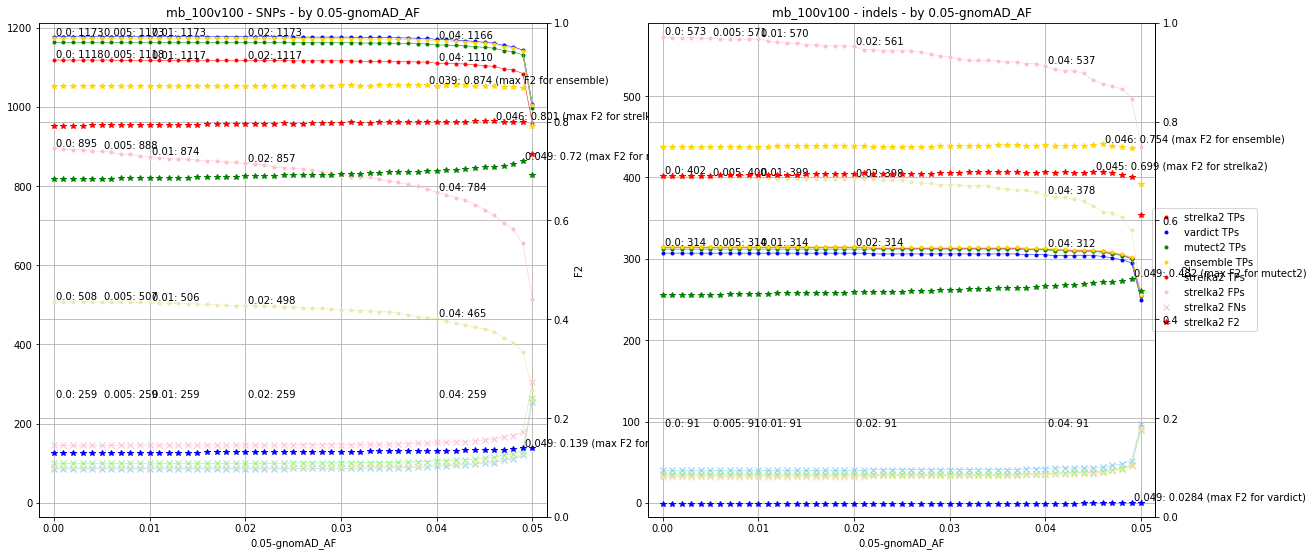

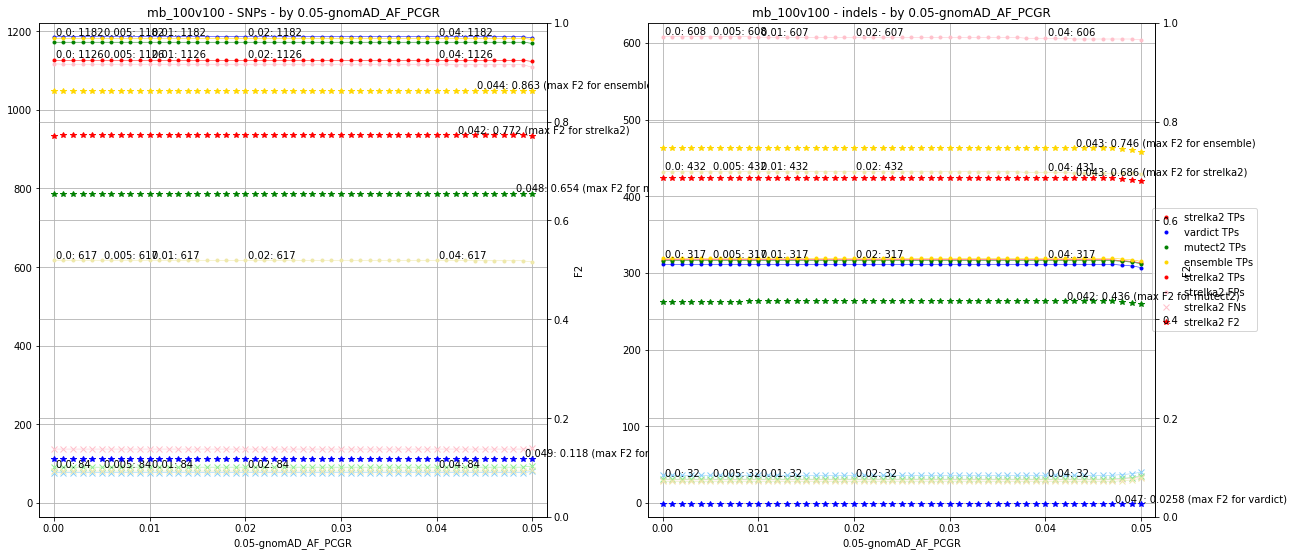

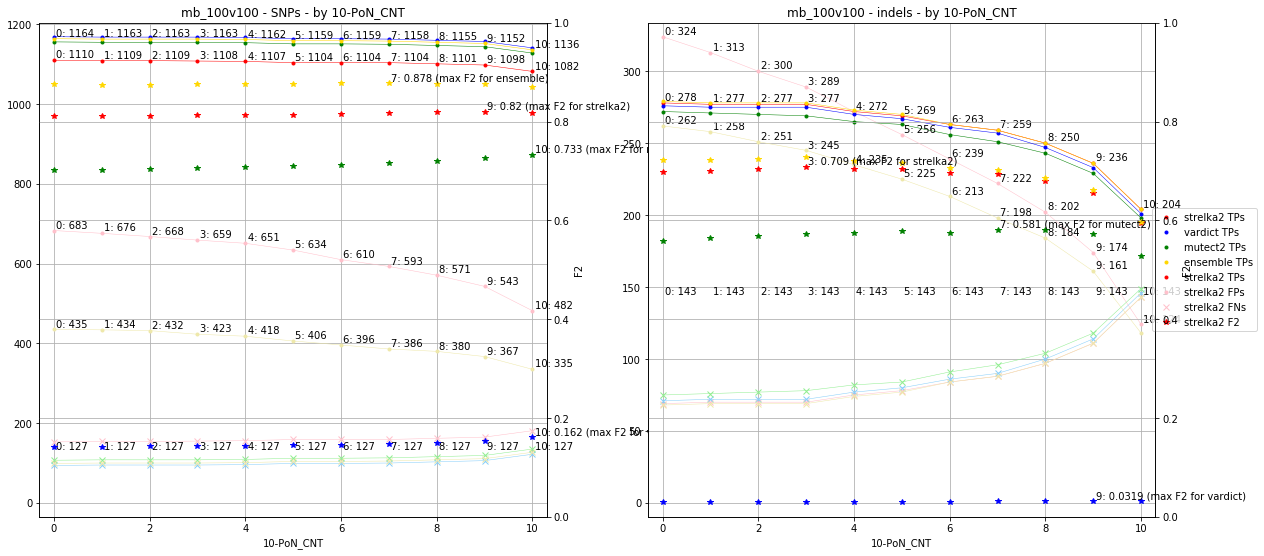

In [32]:
# gnomAD_AF = 0. - no occurences in gnomAD - best variant
# gnomAD_AF = 0.01 - rare in gnomAD - good variant
# gnomAD_AF = 0.1 - common in gnomAD - bad variant

# PoN = 0 - no occurences in PoN - best variant
# PoN = 1 - rare in PoN - candidate for filtering
# PoN = 5 - common in PoN - bad variant

MAX_PON=10
def pon_qry(c):
    return '{val} <= ' + str(MAX_PON) + '-PoN_CNT'
MAX_GNOMAD_AF = 0.05
def gnomad_qry(c):
    return '{val} <= ' + str(MAX_GNOMAD_AF) + '-gnomAD_AF'
def gnomad_qry_pcgr(c):  # PCGR uses exome part of gnomAD
    return '{val} <= ' + str(MAX_GNOMAD_AF) + '-gnomAD_AF_PCGR'

#     pon_cnt = v['PoN_CNT']
#     if np.isnan(pon_cnt): pon_cnt = math.inf

#     pon_level = MAX_PON  # we want pon_level be the-more-the-better
#     for n in range(MAX_PON):
#         if pon_cnt == n:  # PoN_CNT=0 is the best quality, so it translates into the highest value MAX_PON-0
#             return MAX_PON-n
#     return 0  # if PoN_CNT is as high as MAX_PON, we always return the lowest value 0

#PoN_CNT=0  Pon_CNT<=0  pon_level=5-0 = 5
#PoN_CNT=1  Pon_CNT<=1  pon_level=5-1 = 4
#PoN_CNT=4  Pon_CNT<=4  pon_level=5-4 = 1
#PoN_CNT>=5             pon_level=MAX_PON = 5

# plot_roc('mb_100v100', f'PoN_CNT<={MAX_PON}-x (x=0: no filtering)', start=0, end=MAX_PON, step=1, label_step=1, field_fn=field_fn)
# pass

plot_roc('mb_100v100', f'{MAX_GNOMAD_AF}-gnomAD_AF', start=0, end=MAX_GNOMAD_AF, step=0.001, label_step=0.005, get_filt_qry=[], 
         get_qry=gnomad_qry, skip_fp=['vardict', 'mutect2'])
plot_roc('mb_100v100', f'{MAX_GNOMAD_AF}-gnomAD_AF_PCGR_exome', start=0, end=MAX_GNOMAD_AF, step=0.001, label_step=0.005, get_filt_qry=[], 
         get_qry=gnomad_qry_pcgr, skip_fp=['vardict', 'mutect2'])
         
plot_roc('mb_100v100', f'{MAX_PON}-PoN_CNT', start=0, end=MAX_PON, step=1, label_step=1, get_filt_qry=[], 
         get_qry=pon_qry, skip_fp=['vardict', 'mutect2'])

# plot_roc('mb_100v100', 'gnomAD_AF', start=0, end=0.05, step=0.001, label_step=0.005, get_filt_qry=[gnomad_filt1], 
#          get_qry=gnomad_freq_qry, skip_fp=['vardict', 'mutect2'])
# plot_roc('mb_100v100', 'gnomAD_AF', start=0, end=0.05, step=0.001, label_step=0.005, get_filt_qry=[gnomad_filt2], 
#          get_qry=gnomad_freq_qry, skip_fp=['vardict', 'mutect2'])
pass

Plotting mb_100v100
  SNPs...
SNP: True, c=strelka2: tp=1102, fp=605, fn=161, fm=0.8152093504956354, tp/fp=1.8214876033057852
SNP: True, c=vardict: tp=780, fp=4848, fn=483, fm=0.3651685393258427, tp/fp=0.1608910891089109
SNP: True, c=mutect2: tp=1148, fp=1813, fn=115, fm=0.7163359540746287, tp/fp=0.6332046332046332
SNP: True, c=ensemble: tp=1097, fp=109, fn=166, fm=0.876478108021732, tp/fp=10.064220183486238
  indels...
SNP: False, c=strelka2: tp=275, fp=298, fn=72, fm=0.7011728709841917, tp/fp=0.9228187919463087
SNP: False, c=vardict: tp=249, fp=5903, fn=98, fm=0.16511936339522545, tp/fp=0.04218194138573607
SNP: False, c=mutect2: tp=270, fp=699, fn=77, fm=0.5727619855748833, tp/fp=0.38626609442060084
SNP: False, c=ensemble: tp=265, fp=113, fn=82, fm=0.7502831257078142, tp/fp=2.3451327433628317


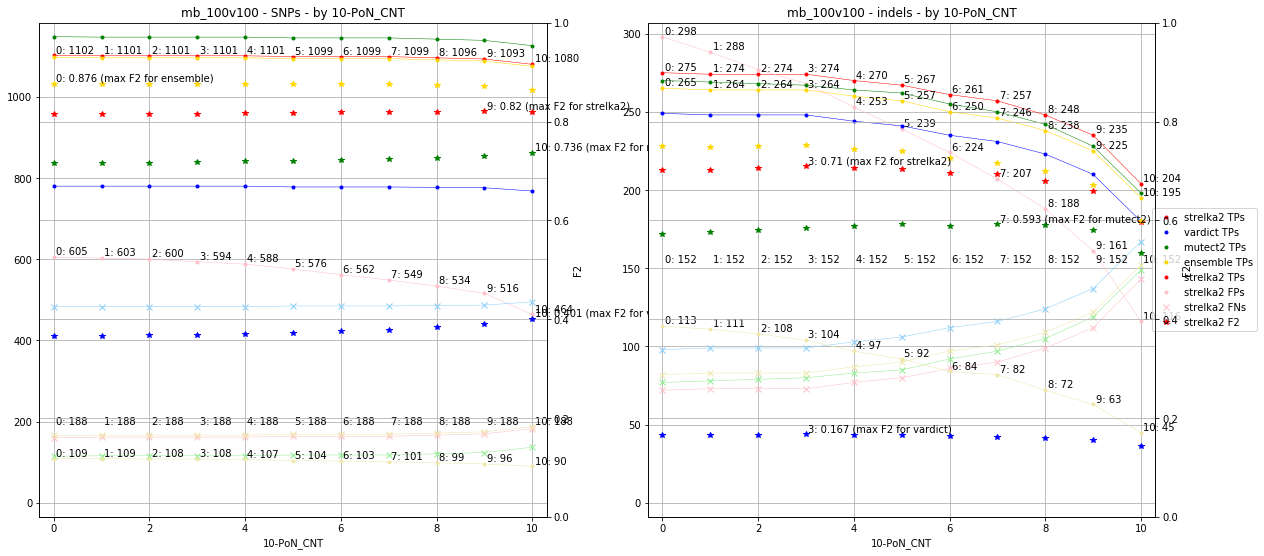

In [23]:
def pon_filt(c, issnp=False):
    if c == 'mutect2' or c == 'vardict':
        return f'PoN_CNT<={0 if issnp else 1}'

def vd_filt_af(c, issnp):
    if c == 'vardict':
        return 'tier<5 or (vardict_INFO_QUAL * TUMOR_AF) >= 10'

def filt_gnomad(c, issnp):
    return 'gnomAD_AF<=0.01'
    
plot_roc('mb_100v100', f'{MAX_PON}-PoN_CNT', start=0, end=MAX_PON, step=1, label_step=1,
         get_filt_qry=[vd_filt_af, filt_gnomad], get_qry=pon_qry, skip_fp=['vardict', 'mutect2'])

# Threshold of 10 shows to be a reasonable one:
# plot_roc('mb_100v100', 'vdQ*AF', start=0, end=1, step=1, label_step=4, get_qry=q_af, get_filt_qry=[vd_filt_af])
#plot_roc('mb_300v50',  'vdQ*AF', start=0, end=41, step=1, label_step=4, get_qry=q_af, get_filt_qry=[vd_filt_af])
#plot_roc('colo_tgen',  'vdQ*AF', start=0, end=41, step=1, label_step=4, get_qry=q_af, get_filt_qry=[pon_filt, vd_filt_af])
pass

Plotting mb_100v100
  SNPs...
SNP: True, c=strelka2: tp=1126, fp=1118, fn=137, fm=0.771655701754386, tp/fp=1.0071556350626119
SNP: True, c=vardict: tp=795, fp=9570, fn=468, fm=0.2578322630862036, tp/fp=0.08307210031347963
SNP: True, c=mutect2: tp=1172, fp=2746, fn=91, fm=0.6532887402452621, tp/fp=0.42680262199563
SNP: True, c=ensemble: tp=1121, fp=199, fn=142, fm=0.8796296296296297, tp/fp=5.633165829145729
  indels...
SNP: False, c=strelka2: tp=317, fp=609, fn=30, fm=0.684961106309421, tp/fp=0.5205254515599343
SNP: False, c=vardict: tp=285, fp=9099, fn=62, fm=0.13228741180839212, tp/fp=0.03132212331025387
SNP: False, c=mutect2: tp=316, fp=1928, fn=31, fm=0.43502202643171806, tp/fp=0.16390041493775934
SNP: False, c=ensemble: tp=306, fp=225, fn=41, fm=0.7972902553413237, tp/fp=1.36
Plotting colo_tgen
  SNPs...
SNP: True, c=strelka2: tp=35136, fp=11718, fn=407, fm=0.9293959561118577, tp/fp=2.9984639016897083
SNP: True, c=vardict: tp=33342, fp=3146, fn=2201, fm=0.933113175864771, tp/fp=10.

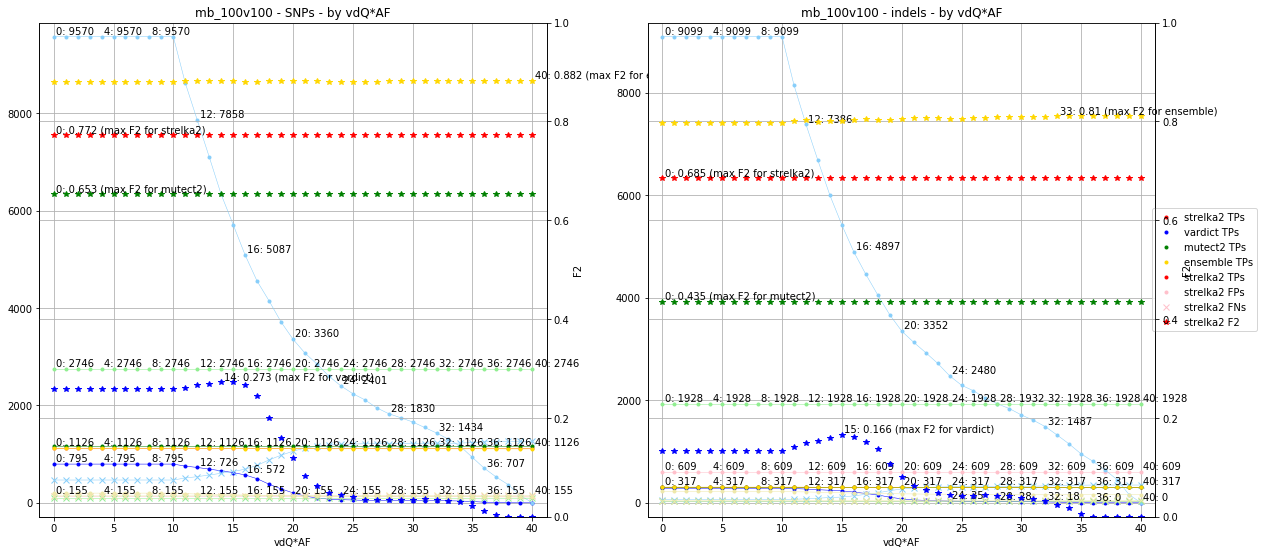

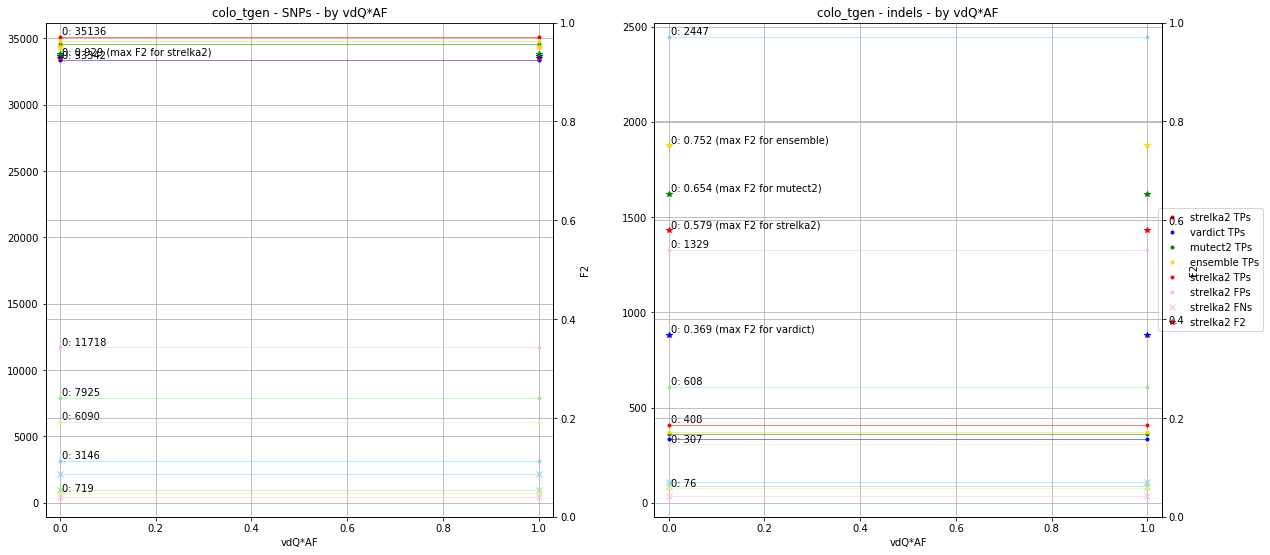

In [22]:
# Keeping vd_filt_af for VarDict ((vardict_INFO_QUAL * TUMOR_AF) >= 10):

def pon_filt(c, issnp=False):
    if c == 'mutect2' or c == 'vardict':
        return f'PoN_CNT<={0 if issnp else 1}'
def vd_filt_af(c, issnp):
    if c == 'vardict':
        return '(vardict_INFO_QUAL * TUMOR_AF) >= 10'

# Threshold of 10 shows to be a reasonable one:
plot_roc('mb_100v100', 'vdQ*AF', start=0, end=1, step=1, label_step=4, get_qry=q_af, get_filt_qry=[vd_filt_af])
#plot_roc('mb_300v50',  'vdQ*AF', start=0, end=1, step=1, label_step=4, get_qry=q_af, get_filt_qry=[vd_filt_af])
plot_roc('colo_tgen',  'vdQ*AF', start=0, end=1, step=1, label_step=4, get_qry=q_af, get_filt_qry=[pon_filt, vd_filt_af])
pass

Plotting mb_100v100
  SNPs...
SNP: True, c=strelka2: tp=1100, fp=352, fn=163, fm=0.8456334563345634
SNP: True, c=vardict: tp=1140, fp=24122, fn=123, fm=0.18803193244045657
SNP: True, c=mutect2: tp=1139, fp=1268, fn=124, fm=0.7635071725432364
SNP: True, c=ensemble: tp=1145, fp=303, fn=118, fm=0.8807692307692309
  indels...
SNP: False, c=strelka2: tp=270, fp=250, fn=77, fm=0.7075471698113207
SNP: False, c=vardict: tp=268, fp=23690, fn=79, fm=0.05286830269075988
SNP: False, c=mutect2: tp=263, fp=590, fn=84, fm=0.5867916108879964
SNP: False, c=ensemble: tp=270, fp=228, fn=77, fm=0.7158006362672323
Plotting mb_100v100
  SNPs...
SNP: True, c=strelka2: tp=1110, fp=683, fn=153, fm=0.8108108108108109
SNP: True, c=vardict: tp=1169, fp=35121, fn=94, fm=0.14138164578394855
SNP: True, c=mutect2: tp=1156, fp=2025, fn=107, fm=0.7020527146848051
SNP: True, c=ensemble: tp=1164, fp=435, fn=99, fm=0.8750563824988724
  indels...
SNP: False, c=strelka2: tp=278, fp=324, fn=69, fm=0.6984924623115577
SNP: Fal

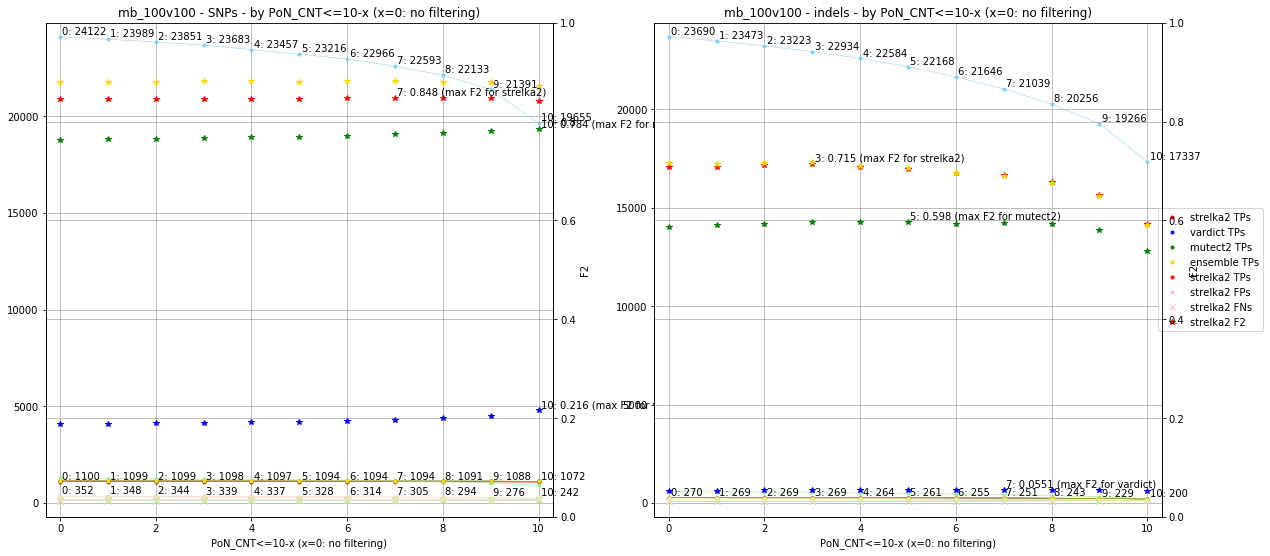

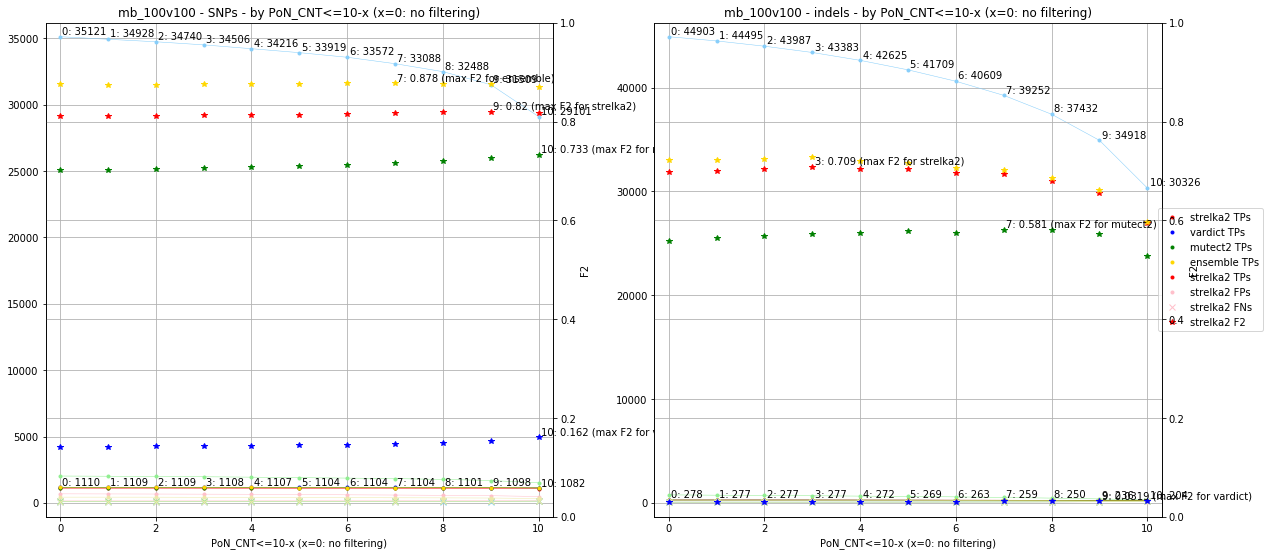

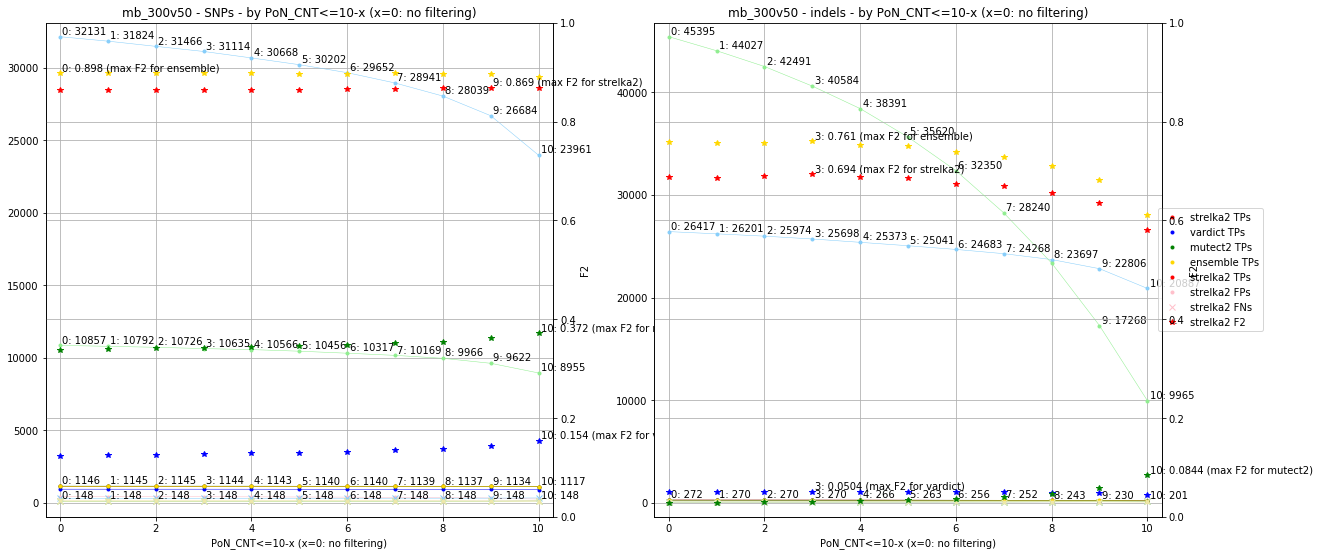

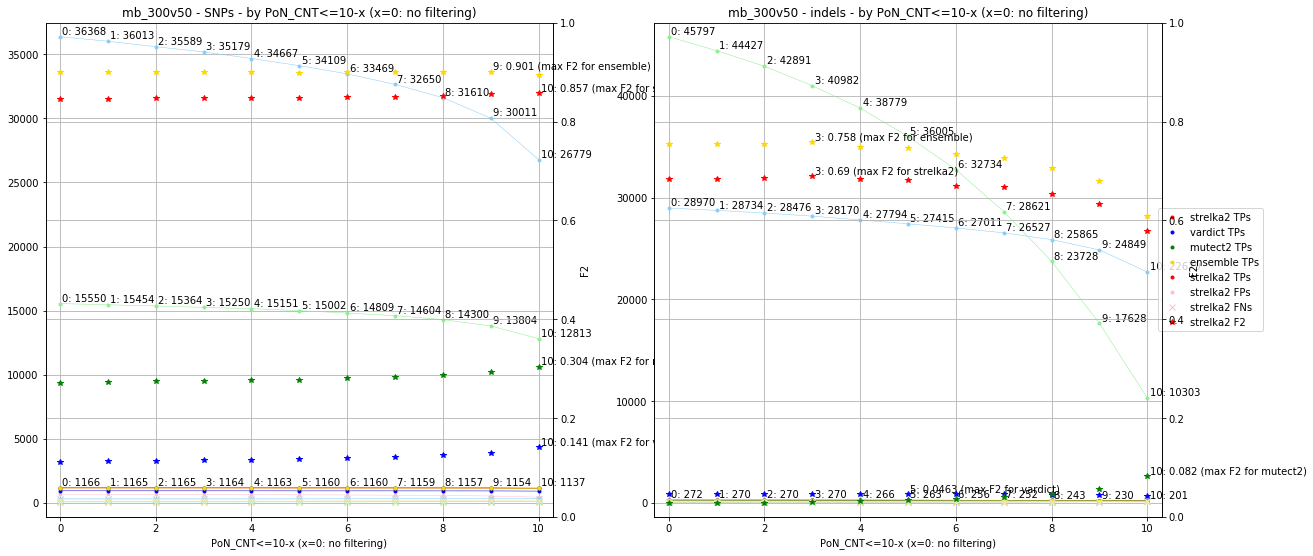

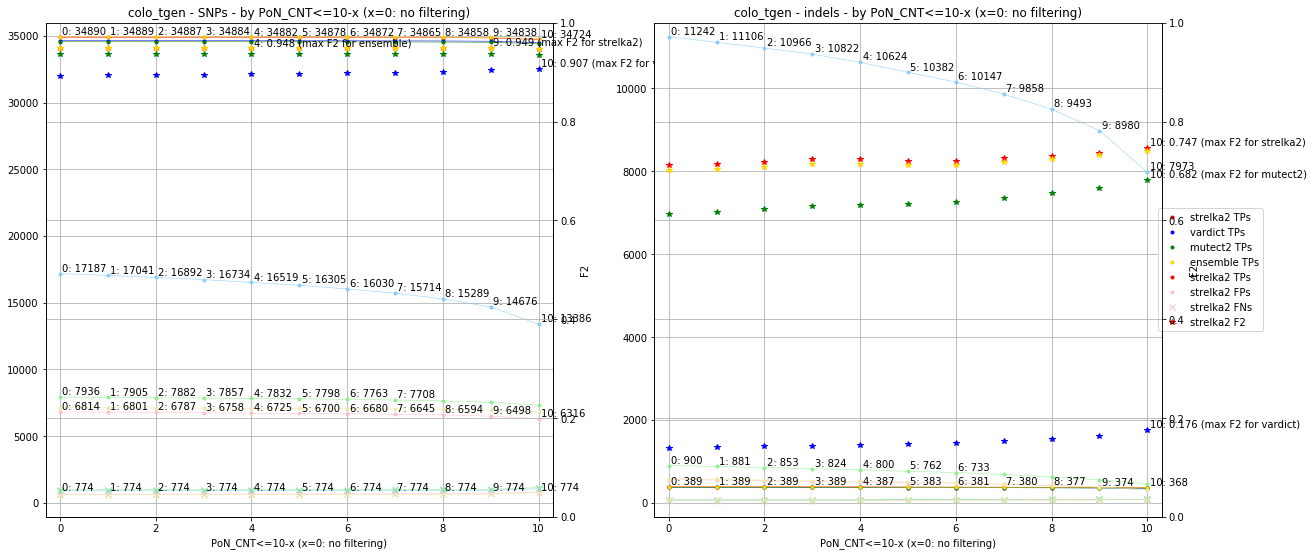

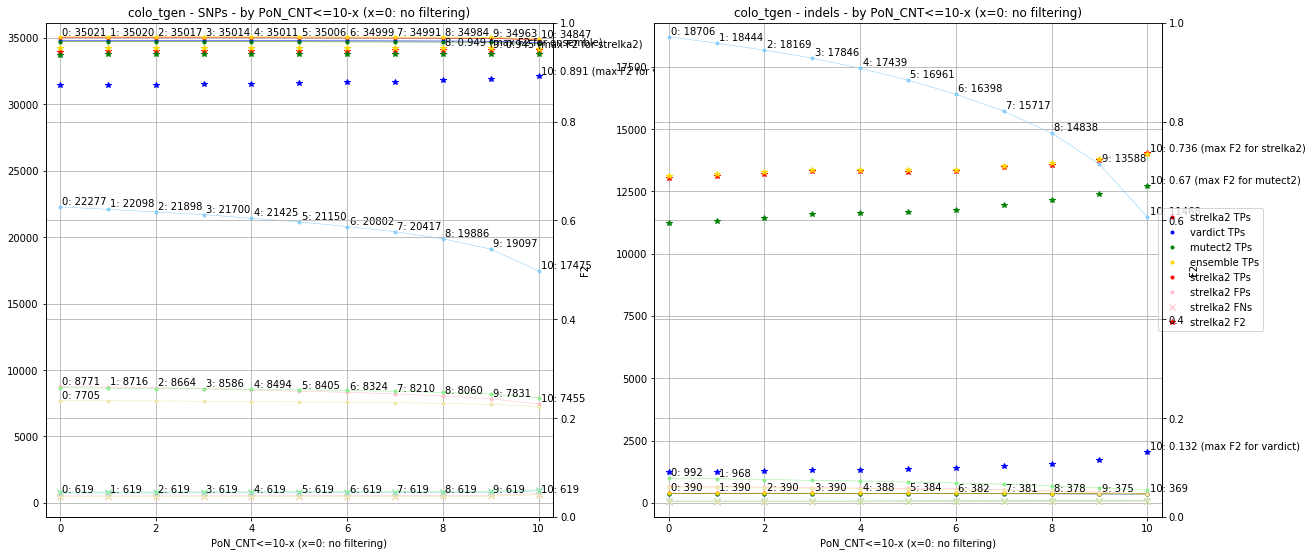

In [36]:
def filt_af_dp(c, issnp):
    return '(TUMOR_AF >= 0.05 & TUMOR_DP >= 25) | GIAB_CONF'
plot_roc('mb_100v100', PON_LBL, start=0, end=MAX_PON, step=1, label_step=1, get_filt_qry=[filt_af_dp], get_qry=get_pon)
plot_roc('mb_100v100', PON_LBL, start=0, end=MAX_PON, step=1, label_step=1, get_filt_qry=[], get_qry=get_pon)
plot_roc('mb_300v50',  PON_LBL, start=0, end=MAX_PON, step=1, label_step=1, get_filt_qry=[filt_af_dp], get_qry=get_pon)
plot_roc('mb_300v50',  PON_LBL, start=0, end=MAX_PON, step=1, label_step=1, get_filt_qry=[], get_qry=get_pon)
plot_roc('colo_tgen',  PON_LBL, start=0, end=MAX_PON, step=1, label_step=1, get_filt_qry=[filt_af_dp], get_qry=get_pon)
plot_roc('colo_tgen',  PON_LBL, start=0, end=MAX_PON, step=1, label_step=1, get_filt_qry=[], get_qry=get_pon)



TRICKY2=="bad_promoter" and tier==1
Plotting mb_100v100
  SNPs...

/Users/vsaveliev/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))



SNP: True, c=strelka2: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
SNP: True, c=vardict: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
SNP: True, c=mutect2: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
SNP: True, c=ensemble: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
  indels...
SNP: False, c=strelka2: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
SNP: False, c=vardict: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
SNP: False, c=mutect2: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
SNP: False, c=ensemble: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0

TRICKY2=="bad_promoter" and tier==2
Plotting mb_100v100
  SNPs...
SNP: True, c=strelka2: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
SNP: True, c=vardict: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
SNP: True, c=mutect2: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
SNP: True, c=ensemble: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
  indels...
SNP: False, c=strelka2: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
SNP: False, c=vardict: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
SNP: False, c=mutect2: tp=0, fp=0, fn=0, fm=0.0, tp/fp=0
SNP: False, c=ensemble: tp=0, fp=0, fn=0, fm=0.0, tp/f

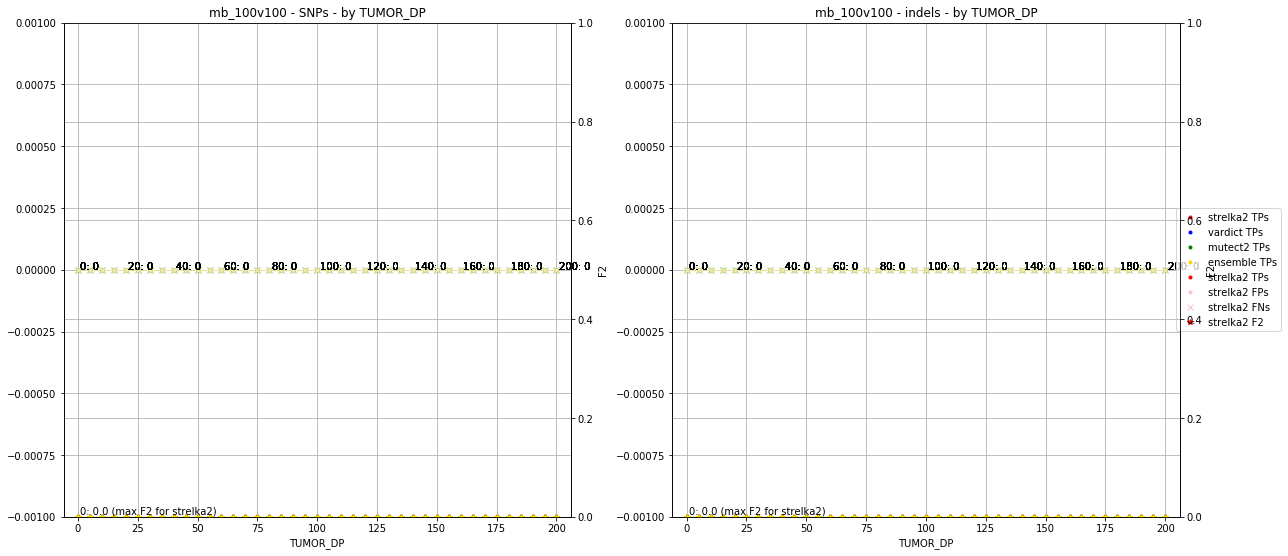

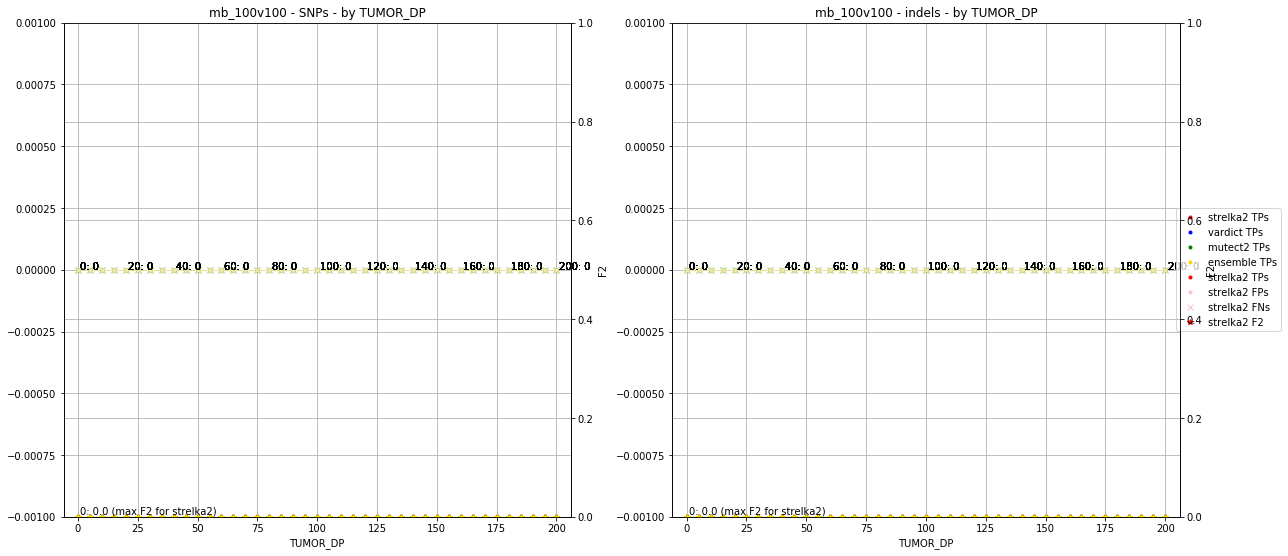

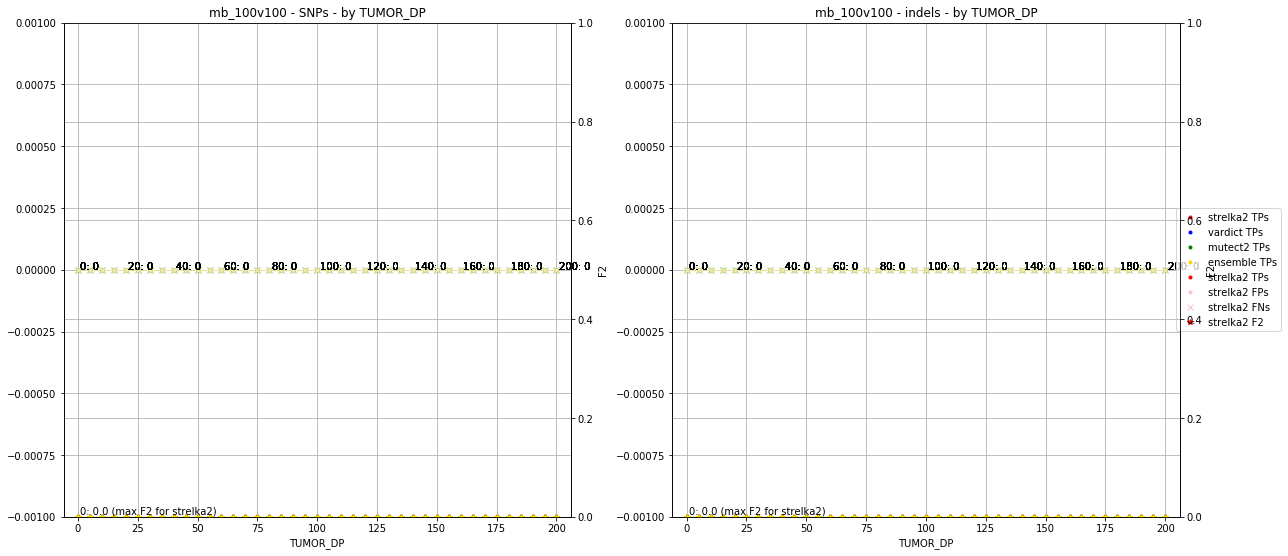

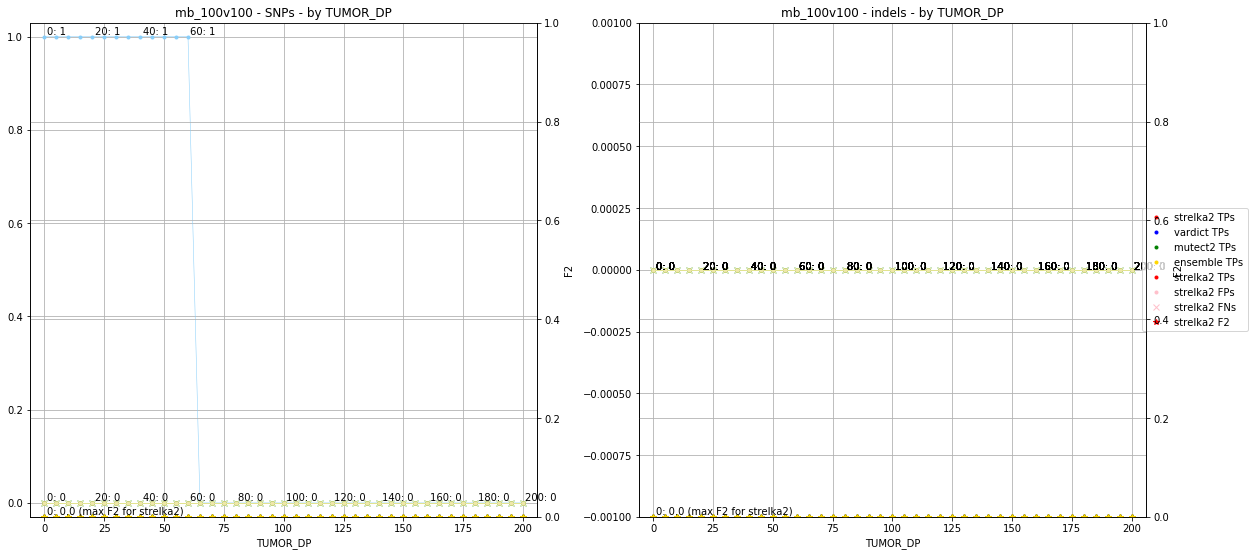

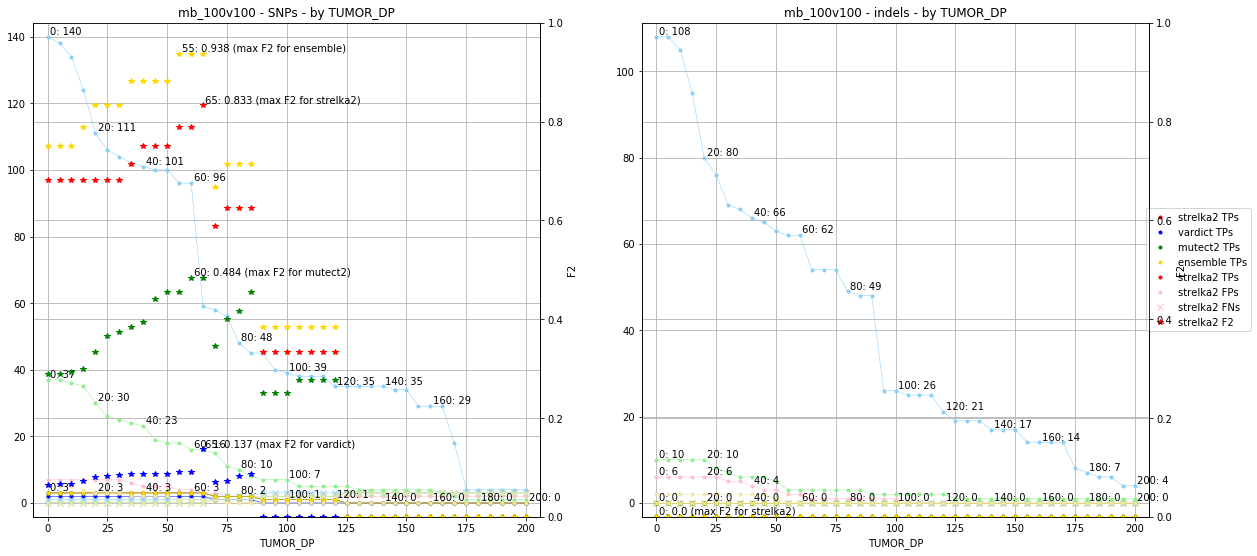

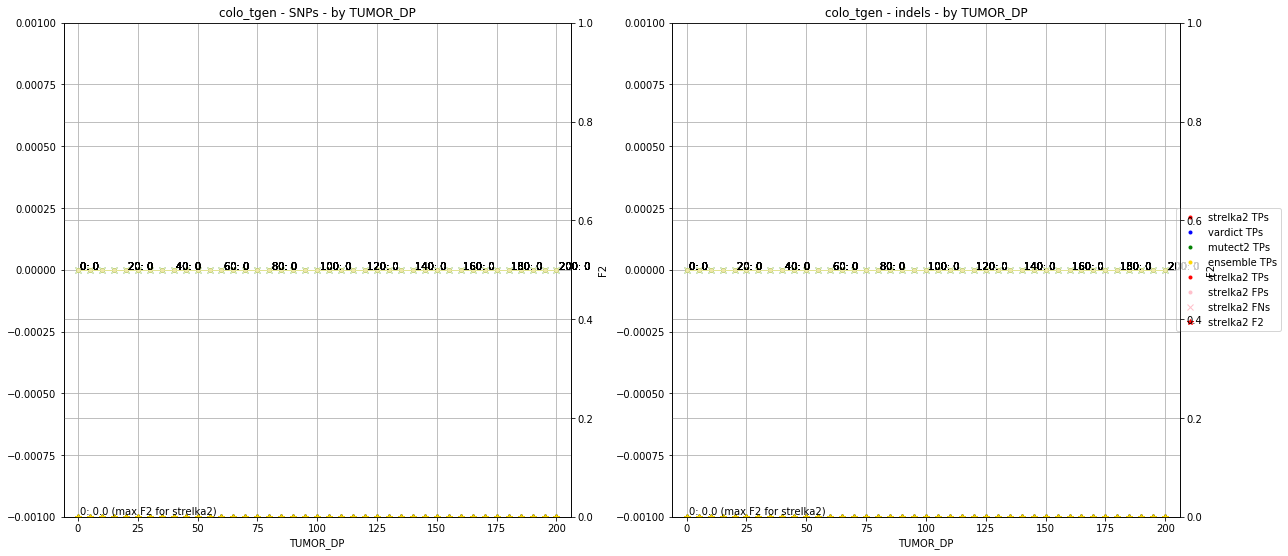

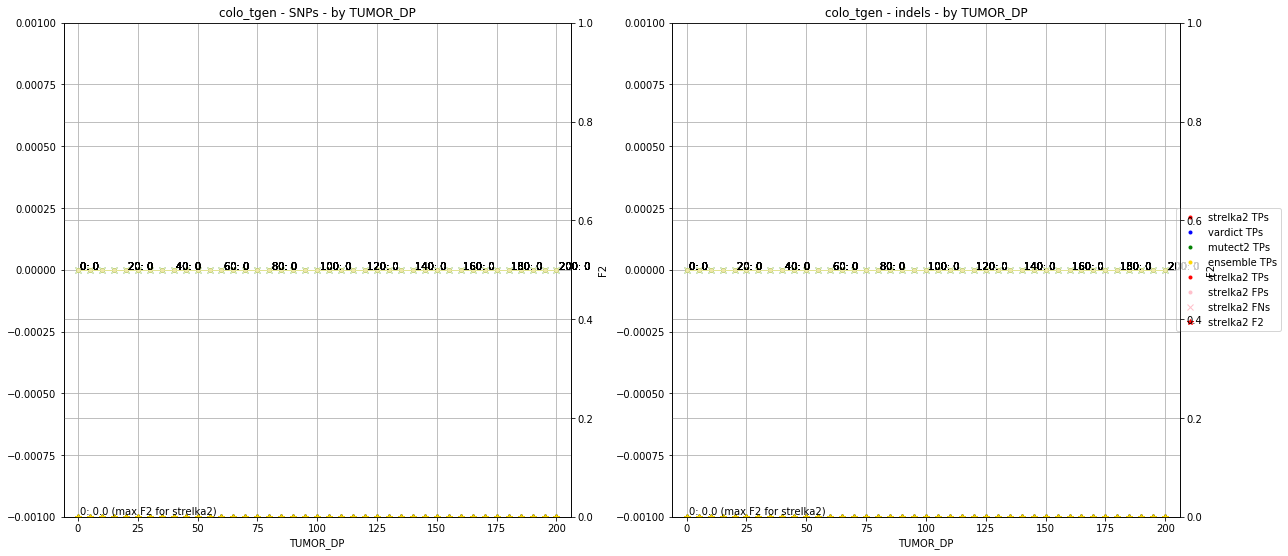

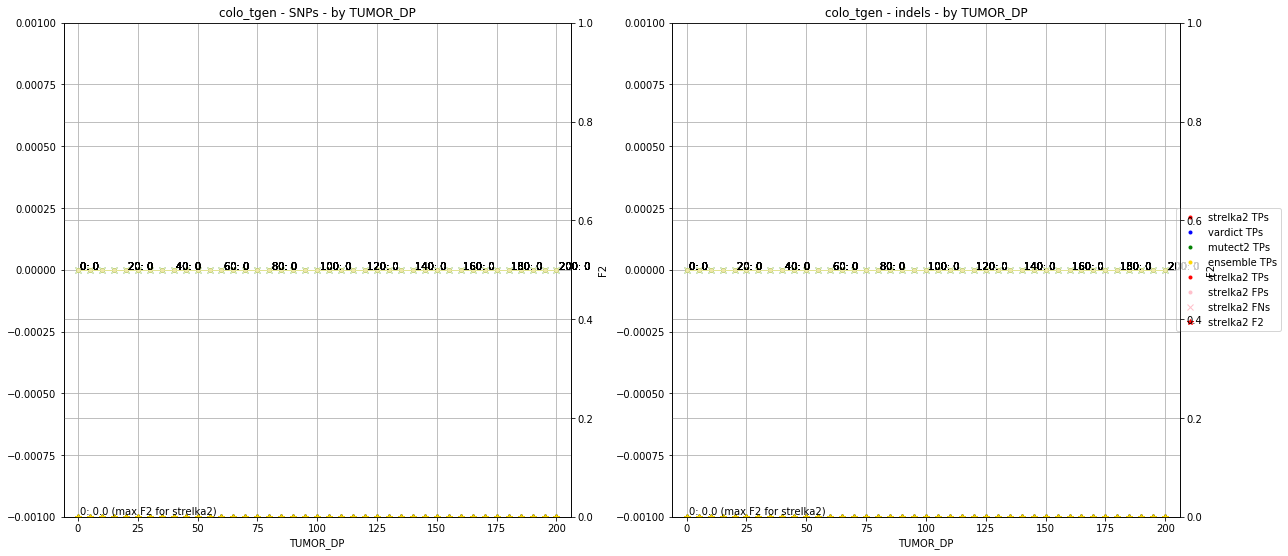

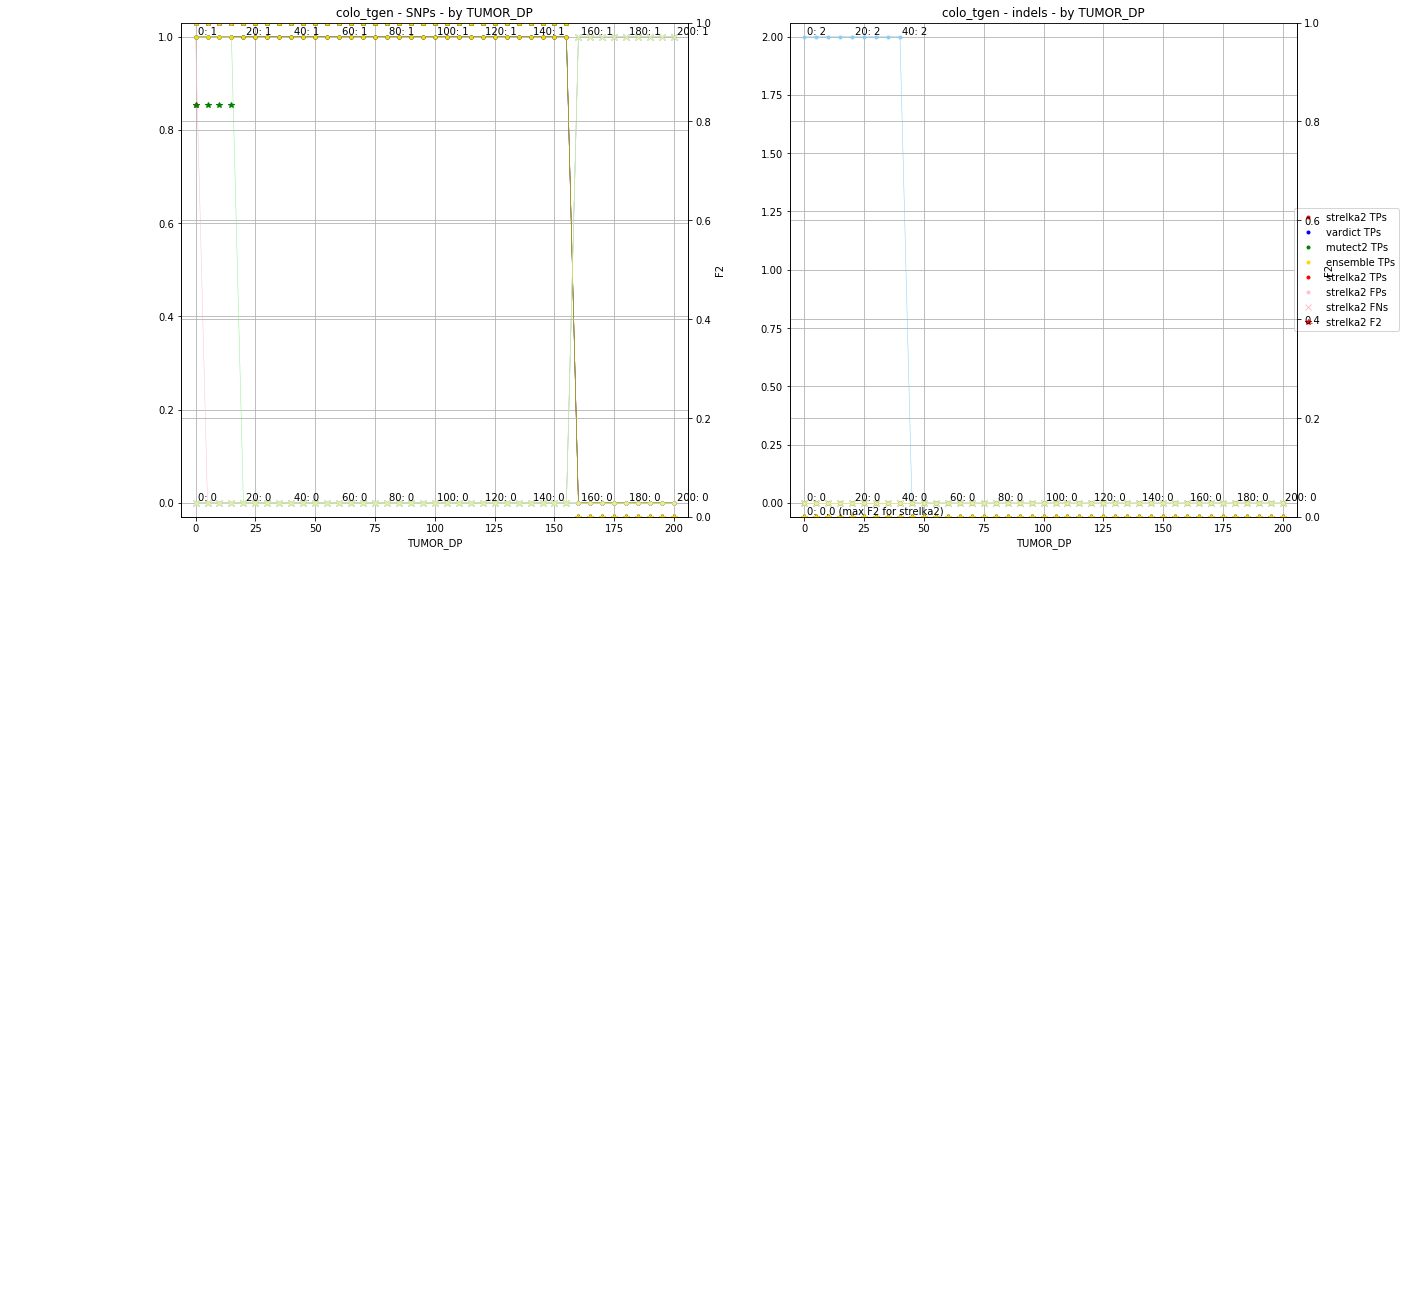

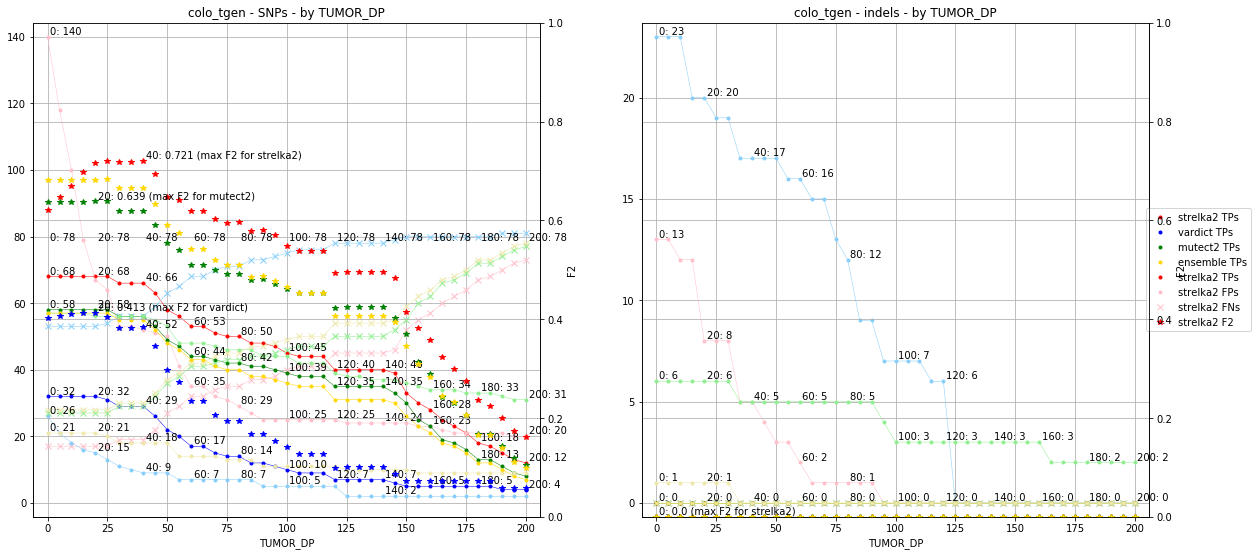

In [30]:
TTs = 'bad_promoter,gc15,gc15to20,gc20to25,gc25to30,gc65to70,gc70to75,gc75to80,gc80to85,gc85,heng_um75-hs37d5,low_complexity_51to200bp,low_complexity_gt200bp,self_chain'.split(',')
def set_tricky2(v):
    tas = v['tricky_anno']
    for TT in TTs:
        if any(ta == TT for ta in tas):
            return TT
    return 0
    
# def set_tricky(v):
#     tas = v['tricky_anno']
#     if all(ta in ['heng_um75-hs37d5', 'self_chain', 'bad_promoter', 'gc20to25', 'gc25to30', 'gc65to70'] for ta in tas):
#         if any(ta == 'heng_um75-hs37d5' for ta in tas):
#             return 3
#         else:
#             return 1
#     elif any(ta for ta in tas):
#         return 0
#     return 2

def qry_cmpl(clr):
    if clr in ['vardict', 'mutect2']:
        return 'Complexity >= {val}'
    else:
        return 'Complexity >= 0'

# def filt_fn(v):
#     cmpl = get_cmpl(v)
#     evs = get_evs(v)
#     return evs > 8

# def _set_field(bn, field, caller):
#     b = benchmark_d[bn]
#     df = df if (df is not None) else benchmark_d[bn]['df']
#     assert df is not None

#     if set_field is not None:
#         df[field] = df.apply(set_field, axis=1)

# plot_roc('mb_100v100', 'Complexity', start=0, end=2, step=1, label_step=1, set_field=set_cmpl_giab, get_qry=qry_cmpl, get_filt_qry=[vd_filt_af])
# plot_roc('mb_300v50',  'Complexity', start=0, end=2, step=1, label_step=1, set_field=set_cmpl_giab, get_qry=qry_cmpl, get_filt_qry=[vd_filt_af])
# plot_roc('colo_tgen',  'Complexity', start=0, end=2, step=1, label_step=1, set_field=set_cmpl_giab, get_qry=qry_cmpl, get_filt_qry=[pon_filt, vd_filt_af])

# plot_roc('mb_100v100', 'Complexity', start=0, end=2, step=1, label_step=1, set_field=set_cmpl_giab, get_filt_qry=[vd_filt_af])
# plot_roc('mb_300v50',  'Complexity', start=0, end=2, step=1, label_step=1, set_field=set_cmpl_giab, get_filt_qry=[vd_filt_af])
# plot_roc('colo_tgen',  'Complexity', start=0, end=2, step=1, label_step=1, set_field=set_cmpl_giab, get_filt_qry=[pon_filt, vd_filt_af])

for bn in ['mb_100v100', 'colo_tgen']:
    df = benchmark_d[bn]['df']
    df['TRICKY2'] = df.apply(set_tricky2, axis=1)

#     plot_roc(bn, 'TUMOR_AF', start=0, end=1, step=1, label_step=1, 
#         get_filt_qry=[vd_filt_af] + ([pon_filt] if bn == 'colo_tgen' else []))
    
#     for region_qry in [
#             'GIAB_CONF or not GIAB_CONF',
#             'IN_CANCER_GENE==True',
#             'IN_CANCER_GENE==True | GIAB_CONF',
#             'IN_CANCER_GENE==True | GIAB_CONF | TRICKY>=1',
#             ]:
#         print(region_qry)
#         plot_roc(bn, 'TUMOR_DP', start=0, end=200, step=5, label_step=20, 
#             get_filt_qry=[vd_filt_af] + ([pon_filt] if bn == 'colo_tgen' else []),
#             df=df.query(region_qry))
    
    region_qrys = []
#     for tt in TTs:
#         region_qrys.append(f'TRICKY2=="{tt}"')
    region_qrys.extend([
        'TRICKY2=="bad_promoter" and tier==1',
        'TRICKY2=="bad_promoter" and tier==2',
        'TRICKY2=="bad_promoter" and tier==3',
        'TRICKY2=="bad_promoter" and tier==4',
        'TRICKY2=="bad_promoter" and tier==5',
#         'GIAB_CONF',
#         'not GIAB_CONF',
#         'tier<5',
    ])
    for region_qry in region_qrys:
        print('')
        print(region_qry)
        plot_roc(bn, 'TUMOR_DP', start=0, end=200, step=5, label_step=20, 
            get_filt_qry=[vd_filt_af] + ([pon_filt] if bn == 'colo_tgen' else []),
            df=df.query(region_qry))
    print('')
    print('')

# plot_roc('mb_100v100', 'Complexity', start=0, end=2, step=1, label_step=1, set_field=set_cmpl_giab, get_qry=qry_cmpl, get_filt_qry=[vd_filt_af])
# plot_roc('mb_300v50',  'Complexity', start=0, end=2, step=1, label_step=1, set_field=set_cmpl_giab, get_qry=qry_cmpl, get_filt_qry=[vd_filt_af])
# plot_roc('colo_tgen',  'Complexity', start=0, end=2, step=1, label_step=1, set_field=set_cmpl_giab, get_qry=qry_cmpl, get_filt_qry=[pon_filt, vd_filt_af])
# plot_roc('mb_100v100', 'Complexity', start=0, end=2, step=1, label_step=1, set_field=set_cmpl_giab, get_filt_qry=[vd_filt_af])
# plot_roc('mb_300v50',  'Complexity', start=0, end=2, step=1, label_step=1, set_field=set_cmpl_giab, get_filt_qry=[vd_filt_af])
# plot_roc('colo_tgen',  'Complexity', start=0, end=2, step=1, label_step=1, set_field=set_cmpl_giab, get_filt_qry=[pon_filt, vd_filt_af])

#plot_roc('mb', 'Complexity', start=0, end=2, step=1, label_step=1, show_values=True, field_fn=get_cmpl)
#plot_roc('mb_100v100', 'Complexity*EVS', start=6, end=20, step=1, label_step=5, field_fn=get_evs, filt_fn=filt_fn)
pass

# TODO:
# types of regions:
# - GIAB confident
# - tricky (level bad and level fine)
# - Cancer genes
# - CACAO regions
# 
# Build VENN diagram of each region
# Build VENN diagram of variants in each region
# Build VENN diagram of TP in each region
# Build VENN diagram of FP in each region
# TP/FP/FN/F2 plots while moving between types of regions:
#    0 - Cancer+CACAO, 1 - GIAB confident (alone or in addition to 0), 2 - no overlap, 3 - tricky level fine (minus 0&1?), 4 - tricky level bad (minus 0&1?)
#
# - Call with 1%
# - Run PCGR annotation (VEP+vcfanno) as well as predispose annotation
# - Tier 1 - keep all 1%
# - Tier 2 - keep 5%
# - Tier 3 - keep 10%
# 
# Next step: keep the vd_filt_af and pon_filt filters, and just follow Hartwig's paper
#
#
# Low FP ratio:
# - GIAB_CONF, TRICKY=1, TRICKY=2 (mb)
#

Plotting mb_100v100
  SNPs...
SNP: True, c=strelka2: tp=1123, fp=1075, fn=140, fm=0.7744827586206896
SNP: True, c=vardict: tp=795, fp=9570, fn=468, fm=0.2578322630862036
SNP: True, c=mutect2: tp=1166, fp=1982, fn=97, fm=0.7109756097560976
SNP: True, c=ensemble: tp=1118, fp=196, fn=145, fm=0.8781024191014768
  indels...
SNP: False, c=strelka2: tp=317, fp=598, fn=30, fm=0.6882327399044725
SNP: False, c=vardict: tp=285, fp=9099, fn=62, fm=0.13228741180839212
SNP: False, c=mutect2: tp=316, fp=1867, fn=31, fm=0.4424530943713245
SNP: False, c=ensemble: tp=306, fp=225, fn=41, fm=0.7972902553413237


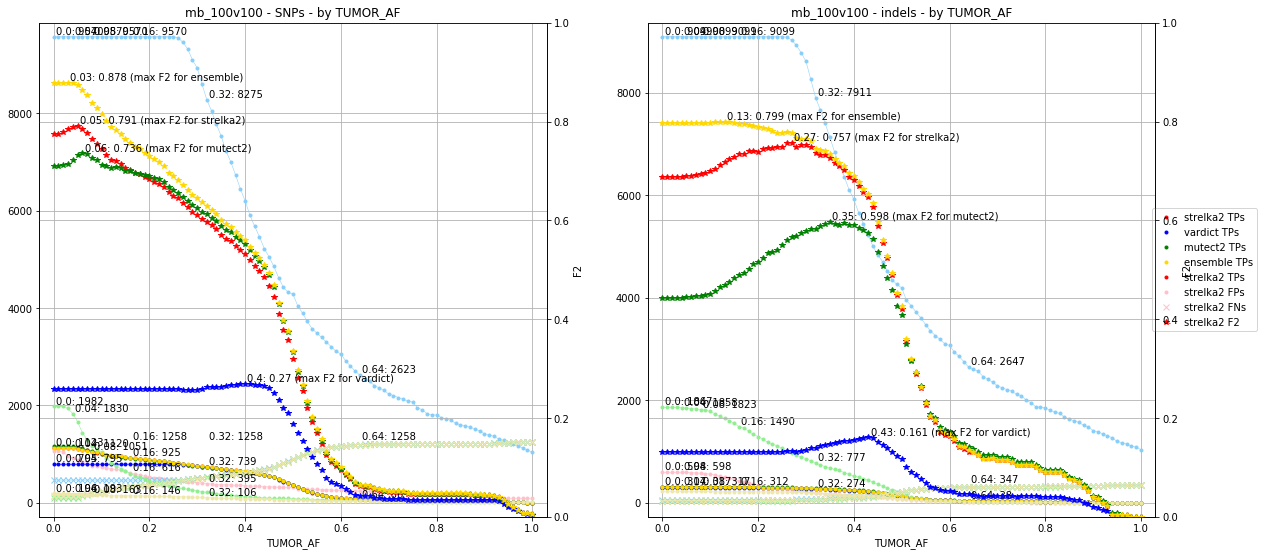

In [49]:
def cmpl_filt_qry(clr, issnp):
    return 'GIAB_CONF | TUMOR_AF>=0.1 | TRICKY==2'

plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02, get_filt_qry=[vd_filt_af, cmpl_filt_qry]          )
#plot_roc('mb_300v50',  'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02, get_filt_qry=[vd_filt_af, cmpl_filt_qry]          )
#plot_roc('colo_tgen',  'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02, get_filt_qry=[pon_filt, vd_filt_af, cmpl_filt_qry])


Plotting mb_100v100
  SNPs...
SNP: True, c=strelka2: tp=1126, fp=1118, fn=137, fm=0.771655701754386
SNP: True, c=vardict: tp=795, fp=9570, fn=468, fm=0.2578322630862036
SNP: True, c=mutect2: tp=1172, fp=2746, fn=91, fm=0.6532887402452621
SNP: True, c=ensemble: tp=1121, fp=199, fn=142, fm=0.8796296296296297
  indels...
SNP: False, c=strelka2: tp=317, fp=609, fn=30, fm=0.684961106309421
SNP: False, c=vardict: tp=285, fp=9099, fn=62, fm=0.13228741180839212
SNP: False, c=mutect2: tp=316, fp=1928, fn=31, fm=0.43502202643171806
SNP: False, c=ensemble: tp=306, fp=225, fn=41, fm=0.7972902553413237


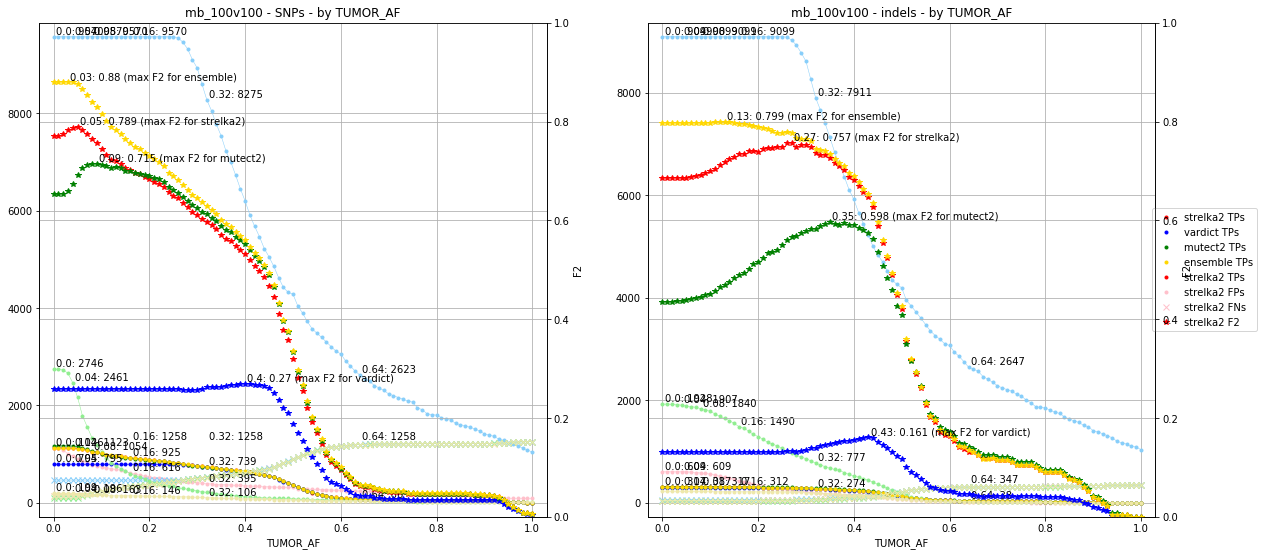

In [48]:
plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02, get_filt_qry=[vd_filt_af]          )

Plotting mb_100v100
  SNPs...
SNP: True, c=strelka2: tp=1121, fp=1084, fn=142, fm=0.7723577235772359
SNP: True, c=vardict: tp=795, fp=9570, fn=468, fm=0.2578322630862036
SNP: True, c=mutect2: tp=1162, fp=2129, fn=101, fm=0.6963921850653242
SNP: True, c=ensemble: tp=1116, fp=194, fn=147, fm=0.8770826784030177
  indels...
SNP: False, c=strelka2: tp=317, fp=597, fn=30, fm=0.6885317115551693
SNP: False, c=vardict: tp=285, fp=9099, fn=62, fm=0.13228741180839212
SNP: False, c=mutect2: tp=316, fp=1880, fn=31, fm=0.44084821428571436
SNP: False, c=ensemble: tp=306, fp=225, fn=41, fm=0.7972902553413237


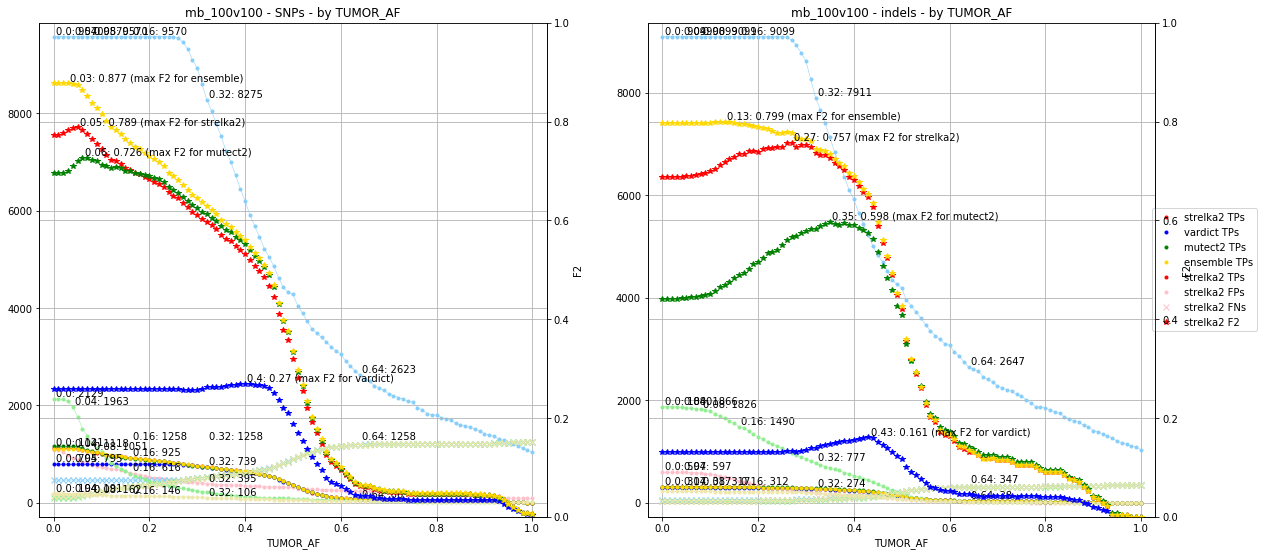

In [46]:
def cmpl_filt_qry(clr, issnp):
    return 'TUMOR_AF>=0.1 | TRICKY>=1'
plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02, get_filt_qry=[vd_filt_af, cmpl_filt_qry])

Plotting mb_100v100
  SNPs...
SNP: True, c=strelka2: tp=1124, fp=1104, fn=139, fm=0.7719780219780219
SNP: True, c=vardict: tp=795, fp=9570, fn=468, fm=0.2578322630862036
SNP: True, c=mutect2: tp=1167, fp=2167, fn=96, fm=0.6958025280228952
SNP: True, c=ensemble: tp=1119, fp=197, fn=144, fm=0.878611809045226
  indels...
SNP: False, c=strelka2: tp=317, fp=601, fn=30, fm=0.6873373807458804
SNP: False, c=vardict: tp=285, fp=9099, fn=62, fm=0.13228741180839212
SNP: False, c=mutect2: tp=316, fp=1884, fn=31, fm=0.44035674470457076
SNP: False, c=ensemble: tp=306, fp=225, fn=41, fm=0.7972902553413237


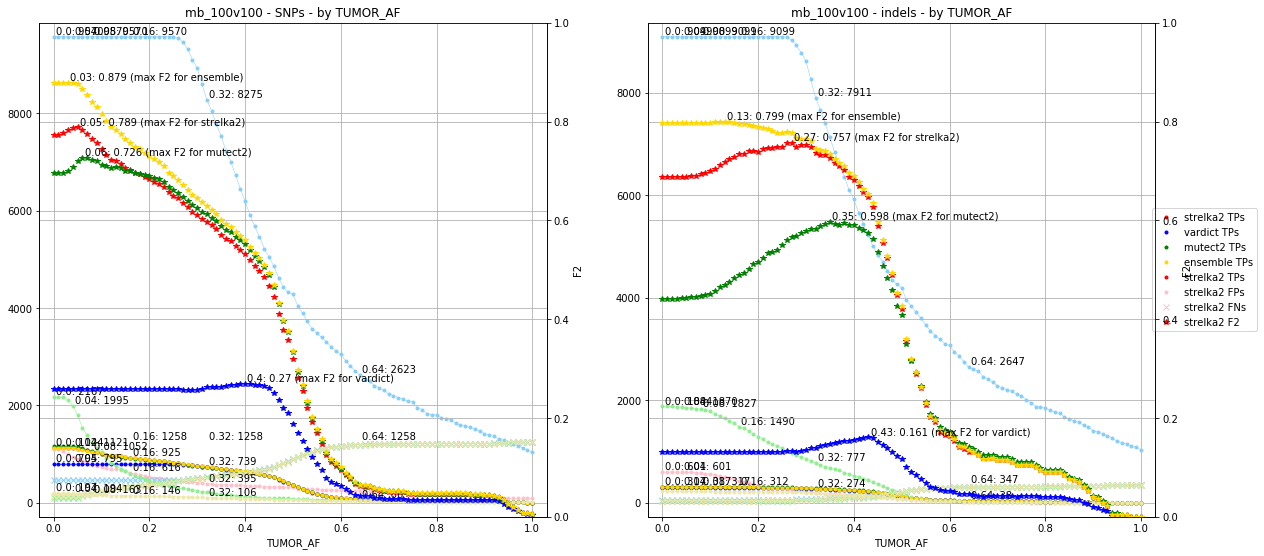

In [47]:
def cmpl_filt_qry(clr, issnp):
    return 'GIAB_CONF | TUMOR_AF>=0.1 | TRICKY>=1'
plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02, get_filt_qry=[vd_filt_af, cmpl_filt_qry])

In [ ]:
def cmpl_filt_qry(clr, issnp):
    return 'TUMOR_AF>=0.1 | TRICKY>=1'
plot_roc('mb_100v100', 'TUMOR_AF', start=0, end=1, step=0.01, label_step=0.02, get_filt_qry=[vd_filt_af, cmpl_filt_qry])

In [42]:
def complexity(v):
    tas = v['tricky_anno']
    cmpl = 2
    if all(ta in ['heng_um75-hs37d5', 'self_chain', 'bad_promoter', 'gc20to25', 'gc25to30', 'gc65to70']
           for ta in tas):
        cmpl = 1
    elif tas:
        cmpl = 0
    return cmpl
   
def filt_fn(v):
    cmpl = get_cmpl(v)
    evs = get_evs(v)
    return  evs > 8

#plot_roc('mb', 'Complexity', start=0, end=2, step=1, label_step=1, show_values=True, field_fn=get_cmpl)
#plot_roc('mb_100v100', 'Complexity*EVS', start=6, end=20, step=1, label_step=5, field_fn=get_evs, filt_fn=filt_fn)
pass

# Venn

In [213]:
# Counting statistics on per-chromosome basis: unique to BWA vs. unqiue to minimap2 vs. 
# common calls. Drawing summary Venn diagrams for each caller and aligner:
# 
# mm2/bwa ensemble    tp-snp  tp-ind  fp-snp  fp-ind  fn-snp  fn-ind 
# mm2/bwa strelka2    --//--  --//--
# mm2/bwa mutect2     --//--
# mm2/bwa vardict
# v/s/m bwa  
# v/s/m mm2            

from matplotlib_venn import venn2, venn3
from matplotlib import gridspec
import itertools
import math

criteria_name = 'PoN_CNT'
rows_criterias = [1, 2, 3, math.inf]
criteria_op = '<'

def plot_venn(bn, df=None):
    b = benchmark_d[bn]
    df = df if (df is not None) else benchmark_d[bn]['df']

    validation_types = ['tp', 'fp', 'fn']
    event_types = [True, False]  # SNP, non-SNP

    rows_cnt = len(rows_criterias)
    figsize = (18, 3.6*rows_cnt)
    fig = plt.figure(figsize=figsize)
    outer = gridspec.GridSpec(1 + rows_cnt, 
                              1 + len(event_types),
                              height_ratios=[1] + [7]*rows_cnt,
                              width_ratios=[1] + [2*len(validation_types)] * len(event_types))
                              
    def left_col_label(txt, ax):
        plt.text(0, 0.5, txt,
            fontsize=16,
            horizontalalignment='left',
            verticalalignment='center')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)     
        plt.axis('off')
            
    # HEADER
    for is_snp_i, is_snp in enumerate(event_types):
        inner = gridspec.GridSpecFromSubplotSpec(1, len(validation_types), 
                                                 subplot_spec=outer[0, 1 + is_snp_i])
        lbl = 'SNP' if is_snp else 'Indel'
        for typ_i, typ in enumerate(validation_types):
            ax = plt.subplot(inner[typ_i])
            plt.text(0.5, -0.5, f'{lbl}, {typ}',
                fontsize=14,
                horizontalalignment='center',
                verticalalignment='bottom',
            )
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)     
            plt.axis('off')

    # 2-way L vs R, one raw for a criteria
    for criteria_i, criteria in enumerate(rows_criterias):
        ax = plt.subplot(outer[1 + criteria_i, 0])
        left_col_label(f'{criteria_name}{criteria_op}{criteria}' if criteria is not None else '', ax)

        for is_snp_i, is_snp in enumerate(event_types):
            inner = gridspec.GridSpecFromSubplotSpec(1, len(validation_types), 
                             subplot_spec=outer[1 + criteria_i, 1 + is_snp_i])
            lbl = 'SNP' if is_snp else 'Indel'
            for typ_i, typ in enumerate(validation_types):
#                dbg.set_trace()
                ax = plt.subplot(inner[typ_i])
                #sets = [set(df.query( & is_snp == {is_snp}').index.tolist())]          
                dff = df.query(f'is_snp == {is_snp}')
                if criteria: dff = dff.query(f'{criteria_name}{criteria_op}{criteria}')
                sets = [set(dff.query(f'{p}_typ == "{typ}"').index.tolist()) for p in [venn_left, venn_right]]    
                venn2(sets, set_labels=[l, r], ax=ax)

#     # 3-way Strelka2 vs Mutect vs VarDict, one raw for each aligner
#     clrs = [c for c in b['callers'] if c != 'ensemble']   
#     for aln_i, aln in enumerate(['bwa', 'mm2']):
#         ax = plt.subplot(outer[1 + len(b['callers']) + aln_i, 0])
#         left_col_label(aln, ax)
        
#         for is_snp_i, is_snp in enumerate(event_types):
#             inner = gridspec.GridSpecFromSubplotSpec(1, len(validation_types), 
#                              subplot_spec=outer[1 + len(b['callers']) + aln_i, 1 + is_snp_i])
#             lbl = 'SNP' if is_snp else 'Indel'
#             for typ_i, typ in enumerate(validation_types):
#                 ax = plt.subplot(inner[typ_i])
#                 sets = [set(df.query(f'{aln}_t == "{typ}" & caller == "{clr}" & is_snp == {is_snp}').index.tolist())
#                         for clr in clrs]                
#                 venn3(sets, set_labels=clrs, ax=ax)
                
plot_venn('mb_ds')
plot_venn('mb_300v50')
plot_venn('colo_40pc_ds')
plot_venn('colo_40pc_full')
plot_venn('colo_tgen')